In [ ]:
import os
import re
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim

# cuda setup
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True} 

In [70]:


# Dimensiones de la imagen
img_width, img_height = 64, 64

# Perfiles y acciones posibles
perfiles = ['front', 'left', 'right']
acciones = sorted(os.listdir("pruebas modelos/Sprites/frames"))  # Asegurar consistencia
num_acciones = len(acciones)  # Debe ser 3
num_perfiles = len(perfiles)  # Debe ser 3
num_movimientos = 8  # Movimientos 0-7

# Expresión regular para extraer el perfil y el número de movimiento
patron_nombre = re.compile(r'^(front|left|right)_\d+_(\d+)\.(png|jpg|jpeg)$')

class SpritesDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convertir a entero
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Listar rutas y etiquetas
ruta_base = "pruebas modelos/Sprites/frames"
rutas_imagenes = []
etiquetas = []

for accion_idx, accion in enumerate(acciones):
    ruta_accion = os.path.join(ruta_base, accion)
    
    if os.path.isdir(ruta_accion):
        for archivo in os.listdir(ruta_accion):
            if archivo.endswith(('.png', '.jpg', '.jpeg')):
                match = patron_nombre.match(archivo)
                
                if match:
                    perfil_str, mov_idx = match.groups()[0], int(match.groups()[1])
                    
                    if mov_idx >= num_movimientos:
                        continue  # Si el número de movimiento es inválido, ignorarlo

                    # Obtener índice del perfil
                    perfil_idx = perfiles.index(perfil_str)

                    rutas_imagenes.append(os.path.join(ruta_accion, archivo))

                    # Etiqueta única: acción * 24 + perfil * 8 + movimiento
                    etiqueta = (accion_idx * num_perfiles * num_movimientos) + (perfil_idx * num_movimientos) + mov_idx
                    etiquetas.append(etiqueta)

# Convertir listas a numpy arrays
rutas_imagenes = np.array(rutas_imagenes)
etiquetas = np.array(etiquetas, dtype=np.int64)  # Convertir etiquetas a enteros

# Dividir en entrenamiento y prueba
rutas_train, rutas_test, etiquetas_train, etiquetas_test = train_test_split(
    rutas_imagenes, etiquetas, test_size=0.2, random_state=42
)

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

# Crear datasets y dataloaders
train_dataset = SpritesDataset(rutas_train, etiquetas_train, transform=transform)
test_dataset = SpritesDataset(rutas_test, etiquetas_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Número total de clases ahora es 72 (3 * 3 * 8)
num_classes = 72  

print(f"Total de imágenes: {len(etiquetas)}")
print(f"Total de clases: {num_classes}")


Total de imágenes: 93312
Total de clases: 72


## VAE

In [ ]:

# Hiperparámetros
batch_size = 32
latent_size = 20
epochs = 50
feature_size = img_width * img_height * 3  # 64x64x3


# Definición del modelo VAE
class VAE(nn.Module):
    def __init__(self, feature_size, latent_size):
        super(VAE, self).__init__()
        self.feature_size = feature_size

        # Encoder
        self.fc1 = nn.Linear(feature_size, 512)
        self.fc21 = nn.Linear(512, latent_size)
        self.fc22 = nn.Linear(512, latent_size)

        # Decoder
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        inputs = torch.cat([x], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        inputs = torch.cat([z], 1)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.feature_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Crear el modelo
model = VAE(feature_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1: Train Loss: 1512.6751, BCE: 1456.0446, KLD: 56.6305
Epoch 1: Test Loss: 1414.9489, BCE: 1364.2826, KLD: 50.6663


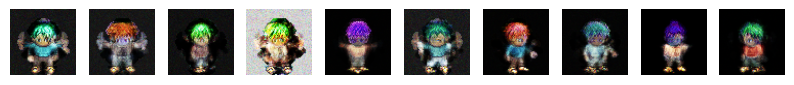

Epoch 2: Train Loss: 1386.6704, BCE: 1338.5089, KLD: 48.1615
Epoch 2: Test Loss: 1376.6110, BCE: 1329.6371, KLD: 46.9739


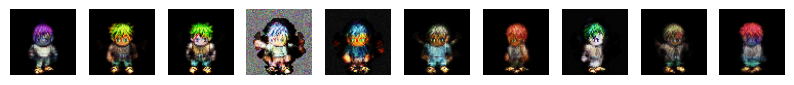

Epoch 3: Train Loss: 1366.4170, BCE: 1319.7640, KLD: 46.6530
Epoch 3: Test Loss: 1365.8854, BCE: 1319.1205, KLD: 46.7649


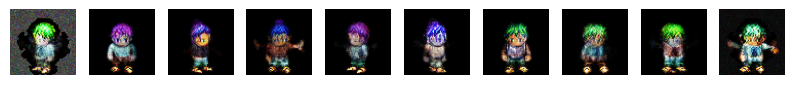

Epoch 4: Train Loss: 1356.4947, BCE: 1310.4585, KLD: 46.0362
Epoch 4: Test Loss: 1361.0833, BCE: 1313.8633, KLD: 47.2200


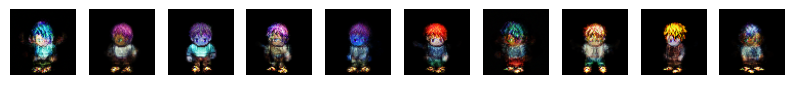

Epoch 5: Train Loss: 1350.2748, BCE: 1304.6801, KLD: 45.5947
Epoch 5: Test Loss: 1351.3784, BCE: 1305.4341, KLD: 45.9443


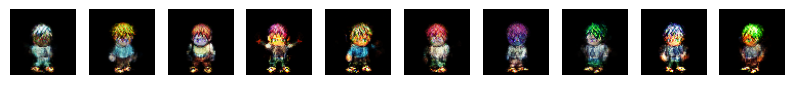

Epoch 6: Train Loss: 1346.1557, BCE: 1300.9608, KLD: 45.1949
Epoch 6: Test Loss: 1346.2292, BCE: 1301.7053, KLD: 44.5239


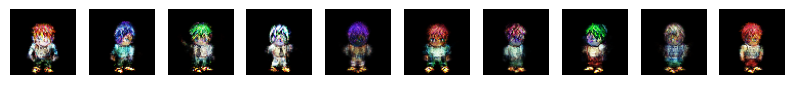

Epoch 7: Train Loss: 1342.8794, BCE: 1297.9874, KLD: 44.8921
Epoch 7: Test Loss: 1345.5797, BCE: 1300.4230, KLD: 45.1568


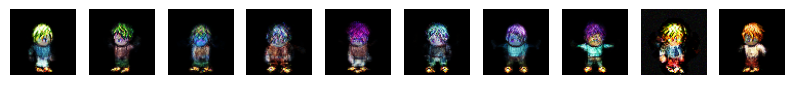

Epoch 8: Train Loss: 1340.2097, BCE: 1295.5762, KLD: 44.6335
Epoch 8: Test Loss: 1340.6697, BCE: 1296.4916, KLD: 44.1781


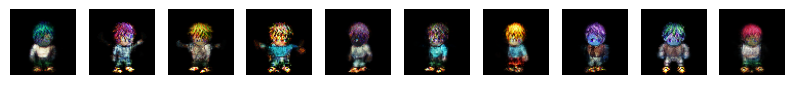

Epoch 9: Train Loss: 1338.0719, BCE: 1293.6743, KLD: 44.3975
Epoch 9: Test Loss: 1340.3712, BCE: 1295.4714, KLD: 44.8998


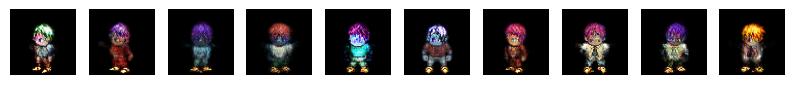

Epoch 10: Train Loss: 1336.3559, BCE: 1292.1965, KLD: 44.1594
Epoch 10: Test Loss: 1339.0037, BCE: 1293.6339, KLD: 45.3698


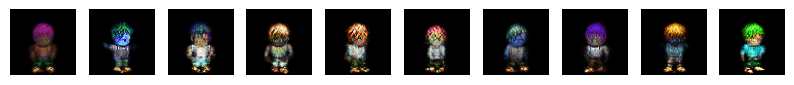

Epoch 11: Train Loss: 1334.6944, BCE: 1290.7098, KLD: 43.9845
Epoch 11: Test Loss: 1337.5727, BCE: 1293.7913, KLD: 43.7814


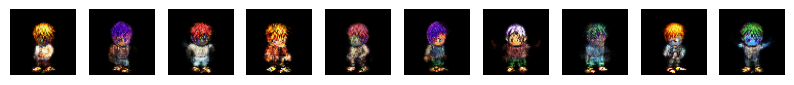

Epoch 12: Train Loss: 1333.4713, BCE: 1289.6762, KLD: 43.7951
Epoch 12: Test Loss: 1338.6771, BCE: 1294.7410, KLD: 43.9361


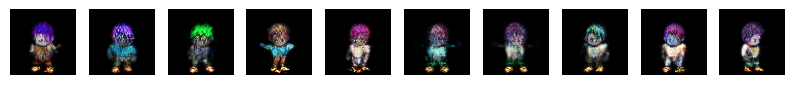

Epoch 13: Train Loss: 1332.2525, BCE: 1288.6366, KLD: 43.6159
Epoch 13: Test Loss: 1335.9726, BCE: 1291.9582, KLD: 44.0144


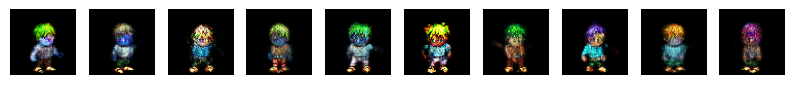

Epoch 14: Train Loss: 1331.3061, BCE: 1287.8479, KLD: 43.4582
Epoch 14: Test Loss: 1334.0004, BCE: 1291.5720, KLD: 42.4284


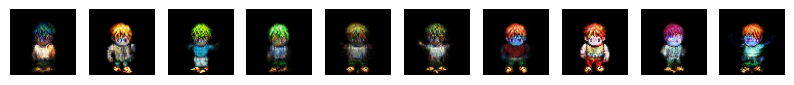

Epoch 15: Train Loss: 1330.1539, BCE: 1286.8190, KLD: 43.3348
Epoch 15: Test Loss: 1332.2128, BCE: 1288.5897, KLD: 43.6231


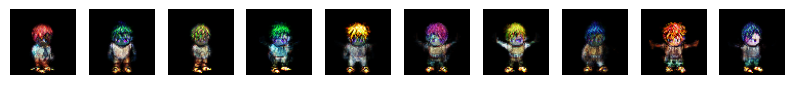

Epoch 16: Train Loss: 1329.4712, BCE: 1286.2964, KLD: 43.1748
Epoch 16: Test Loss: 1333.8371, BCE: 1290.6825, KLD: 43.1546


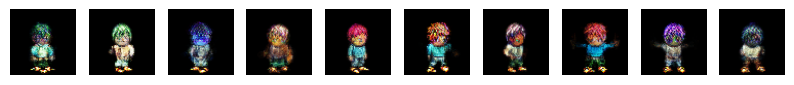

Epoch 17: Train Loss: 1328.6994, BCE: 1285.6103, KLD: 43.0891
Epoch 17: Test Loss: 1331.3468, BCE: 1288.7246, KLD: 42.6222


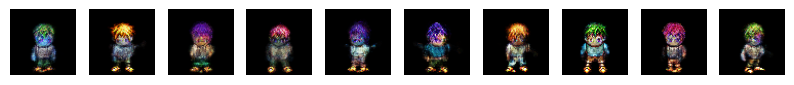

Epoch 18: Train Loss: 1327.8732, BCE: 1284.9532, KLD: 42.9200
Epoch 18: Test Loss: 1331.6158, BCE: 1289.0756, KLD: 42.5402


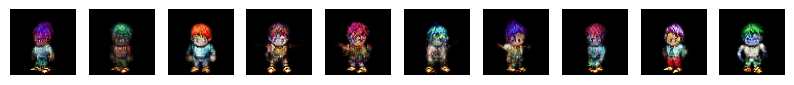

Epoch 19: Train Loss: 1327.1552, BCE: 1284.3228, KLD: 42.8324
Epoch 19: Test Loss: 1331.6032, BCE: 1289.0627, KLD: 42.5404


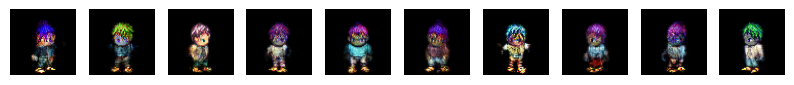

Epoch 20: Train Loss: 1326.7275, BCE: 1283.9883, KLD: 42.7392
Epoch 20: Test Loss: 1331.4768, BCE: 1289.2169, KLD: 42.2598


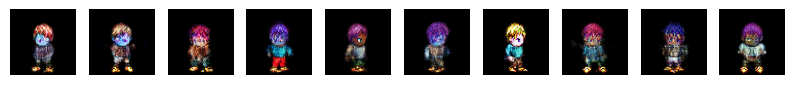

Epoch 21: Train Loss: 1326.1936, BCE: 1283.5611, KLD: 42.6325
Epoch 21: Test Loss: 1328.3978, BCE: 1285.9972, KLD: 42.4006


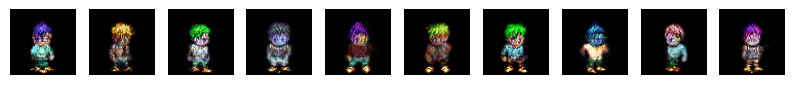

Epoch 22: Train Loss: 1325.6307, BCE: 1283.0591, KLD: 42.5716
Epoch 22: Test Loss: 1330.0784, BCE: 1287.2531, KLD: 42.8252


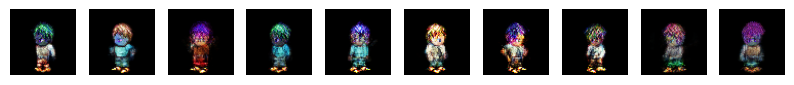

Epoch 23: Train Loss: 1324.9586, BCE: 1282.5266, KLD: 42.4320
Epoch 23: Test Loss: 1326.4004, BCE: 1284.6328, KLD: 41.7677


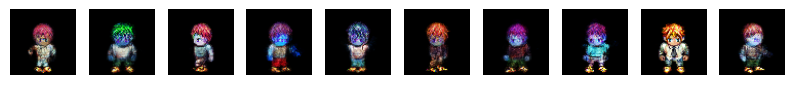

Epoch 24: Train Loss: 1324.6661, BCE: 1282.3141, KLD: 42.3520
Epoch 24: Test Loss: 1328.9233, BCE: 1286.0748, KLD: 42.8485


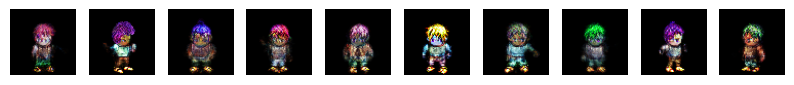

Epoch 25: Train Loss: 1324.1409, BCE: 1281.8871, KLD: 42.2538
Epoch 25: Test Loss: 1327.2290, BCE: 1284.7161, KLD: 42.5129


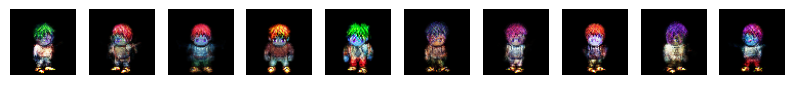

Epoch 26: Train Loss: 1323.7474, BCE: 1281.5553, KLD: 42.1921
Epoch 26: Test Loss: 1327.3620, BCE: 1285.7656, KLD: 41.5963


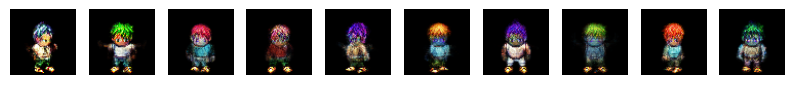

Epoch 27: Train Loss: 1323.4086, BCE: 1281.2756, KLD: 42.1331
Epoch 27: Test Loss: 1325.8360, BCE: 1284.1830, KLD: 41.6529


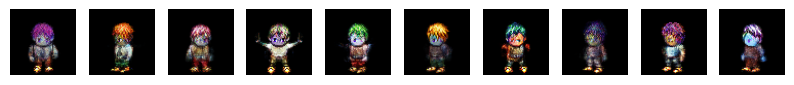

Epoch 28: Train Loss: 1322.9480, BCE: 1280.8907, KLD: 42.0573
Epoch 28: Test Loss: 1326.5605, BCE: 1284.4169, KLD: 42.1436


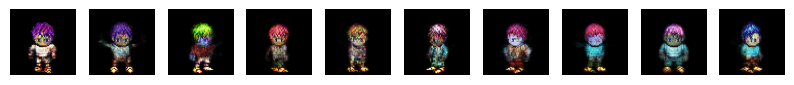

Epoch 29: Train Loss: 1322.5150, BCE: 1280.5299, KLD: 41.9852
Epoch 29: Test Loss: 1326.7780, BCE: 1284.2012, KLD: 42.5769


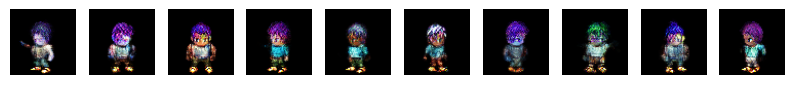

Epoch 30: Train Loss: 1322.3630, BCE: 1280.4430, KLD: 41.9200
Epoch 30: Test Loss: 1324.0958, BCE: 1282.8160, KLD: 41.2798


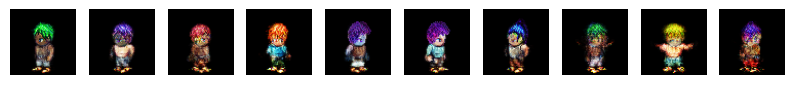

Epoch 31: Train Loss: 1321.9824, BCE: 1280.1101, KLD: 41.8722
Epoch 31: Test Loss: 1324.4533, BCE: 1283.2342, KLD: 41.2191


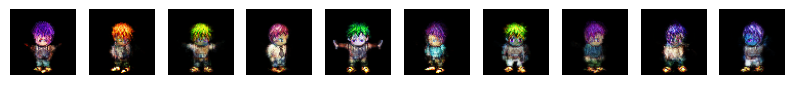

Epoch 32: Train Loss: 1321.6375, BCE: 1279.8638, KLD: 41.7736
Epoch 32: Test Loss: 1328.8191, BCE: 1286.0377, KLD: 42.7814


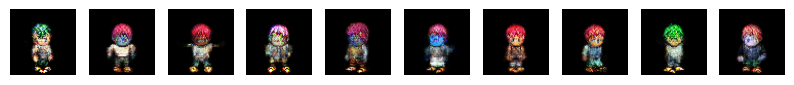

Epoch 33: Train Loss: 1321.4584, BCE: 1279.7228, KLD: 41.7355
Epoch 33: Test Loss: 1322.5204, BCE: 1281.9421, KLD: 40.5782


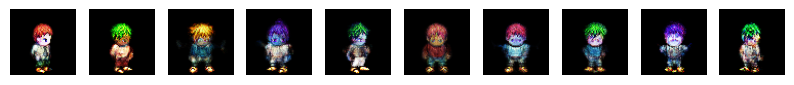

Epoch 34: Train Loss: 1321.1599, BCE: 1279.4591, KLD: 41.7007
Epoch 34: Test Loss: 1324.7191, BCE: 1282.6253, KLD: 42.0939


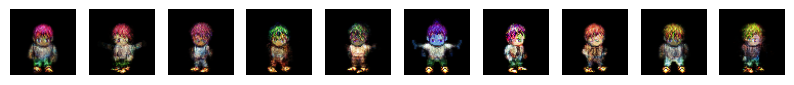

Epoch 35: Train Loss: 1320.9302, BCE: 1279.3092, KLD: 41.6209
Epoch 35: Test Loss: 1325.0037, BCE: 1282.8040, KLD: 42.1997


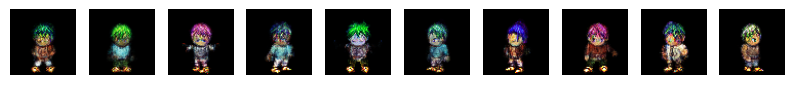

Epoch 36: Train Loss: 1320.5864, BCE: 1279.0387, KLD: 41.5477
Epoch 36: Test Loss: 1327.1832, BCE: 1286.1890, KLD: 40.9942


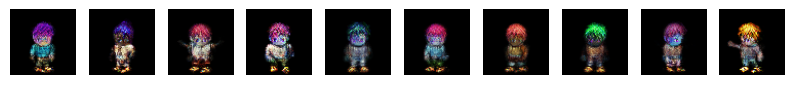

Epoch 37: Train Loss: 1320.4640, BCE: 1278.9520, KLD: 41.5119
Epoch 37: Test Loss: 1322.0846, BCE: 1281.0028, KLD: 41.0818


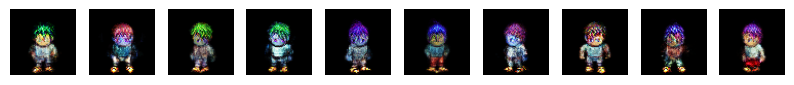

Epoch 38: Train Loss: 1320.0821, BCE: 1278.6135, KLD: 41.4686
Epoch 38: Test Loss: 1324.9795, BCE: 1283.6169, KLD: 41.3626


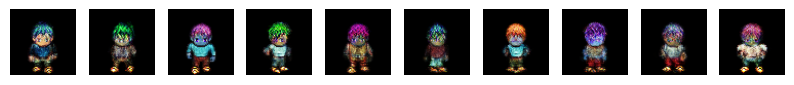

Epoch 39: Train Loss: 1319.8351, BCE: 1278.4303, KLD: 41.4049
Epoch 39: Test Loss: 1323.9566, BCE: 1282.4218, KLD: 41.5348


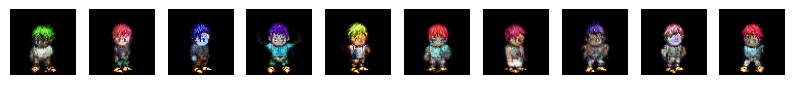

Epoch 40: Train Loss: 1319.7692, BCE: 1278.3801, KLD: 41.3890
Epoch 40: Test Loss: 1322.4317, BCE: 1282.0746, KLD: 40.3570


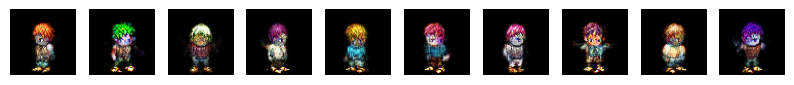

Epoch 41: Train Loss: 1319.4599, BCE: 1278.1372, KLD: 41.3227
Epoch 41: Test Loss: 1323.3998, BCE: 1280.0924, KLD: 43.3074


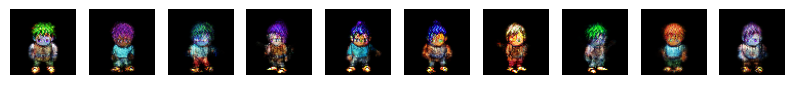

Epoch 42: Train Loss: 1319.3127, BCE: 1278.0115, KLD: 41.3012
Epoch 42: Test Loss: 1321.9448, BCE: 1279.3394, KLD: 42.6055


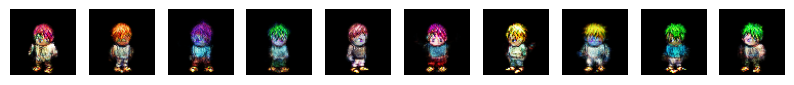

Epoch 43: Train Loss: 1319.2549, BCE: 1277.9901, KLD: 41.2648
Epoch 43: Test Loss: 1322.3895, BCE: 1281.2463, KLD: 41.1433


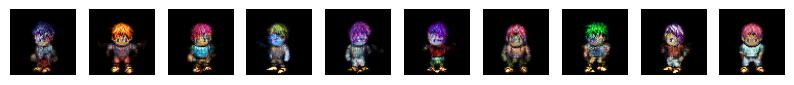

Epoch 44: Train Loss: 1319.1215, BCE: 1277.8610, KLD: 41.2604
Epoch 44: Test Loss: 1322.3097, BCE: 1281.5411, KLD: 40.7687


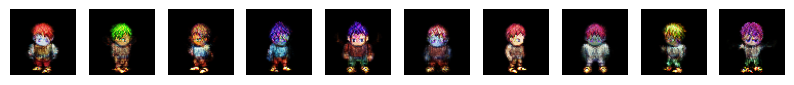

Epoch 45: Train Loss: 1318.6944, BCE: 1277.5500, KLD: 41.1444
Epoch 45: Test Loss: 1321.9187, BCE: 1281.0907, KLD: 40.8280


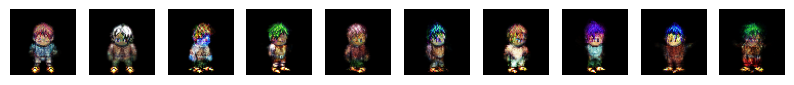

Epoch 46: Train Loss: 1318.6404, BCE: 1277.4954, KLD: 41.1451
Epoch 46: Test Loss: 1323.9802, BCE: 1283.3513, KLD: 40.6289


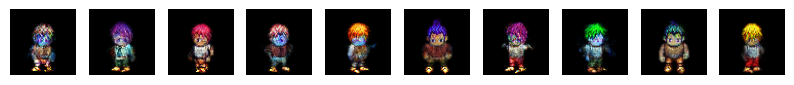

Epoch 47: Train Loss: 1318.4865, BCE: 1277.3857, KLD: 41.1008
Epoch 47: Test Loss: 1320.9109, BCE: 1281.0149, KLD: 39.8961


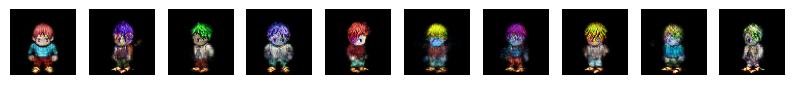

Epoch 48: Train Loss: 1318.3568, BCE: 1277.2776, KLD: 41.0792
Epoch 48: Test Loss: 1325.2129, BCE: 1283.7141, KLD: 41.4987


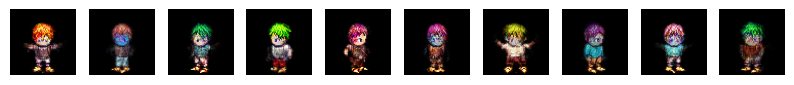

Epoch 49: Train Loss: 1318.1666, BCE: 1277.1660, KLD: 41.0005
Epoch 49: Test Loss: 1324.8205, BCE: 1283.7996, KLD: 41.0209


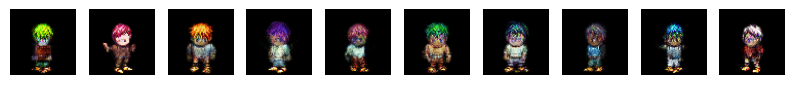

Epoch 50: Train Loss: 1318.0531, BCE: 1277.0632, KLD: 40.9899
Epoch 50: Test Loss: 1320.9005, BCE: 1279.9015, KLD: 40.9990


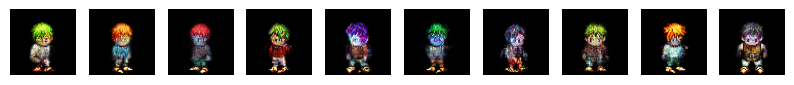

In [ ]:


# Almacenar las pérdidas
train_losses = []
test_losses = []

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, feature_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # Divergencia KL
    return BCE + KLD, BCE, KLD

def train(epoch):
    model.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    train_losses.append((avg_loss, avg_bce, avg_kld))
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")

def test(epoch):
    model.eval()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    with torch.no_grad():
        for (data, labels) in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()

    avg_loss = total_loss / len(test_loader.dataset)
    avg_bce = total_bce / len(test_loader.dataset)
    avg_kld = total_kld / len(test_loader.dataset)

    test_losses.append((avg_loss, avg_bce, avg_kld))
    print(f"Epoch {epoch}: Test Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")

# Entrenamiento
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    #Dibujar entre epocas
    with torch.no_grad():
        sample = torch.randn(10, latent_size).to(device)
        sample = model.decode(sample).cpu()
        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for j in range(10):
            axes[j].imshow(sample.view(10, 3, 64, 64)[j].permute(1, 2, 0).cpu().numpy())
            axes[j].axis("off")
        plt.show()



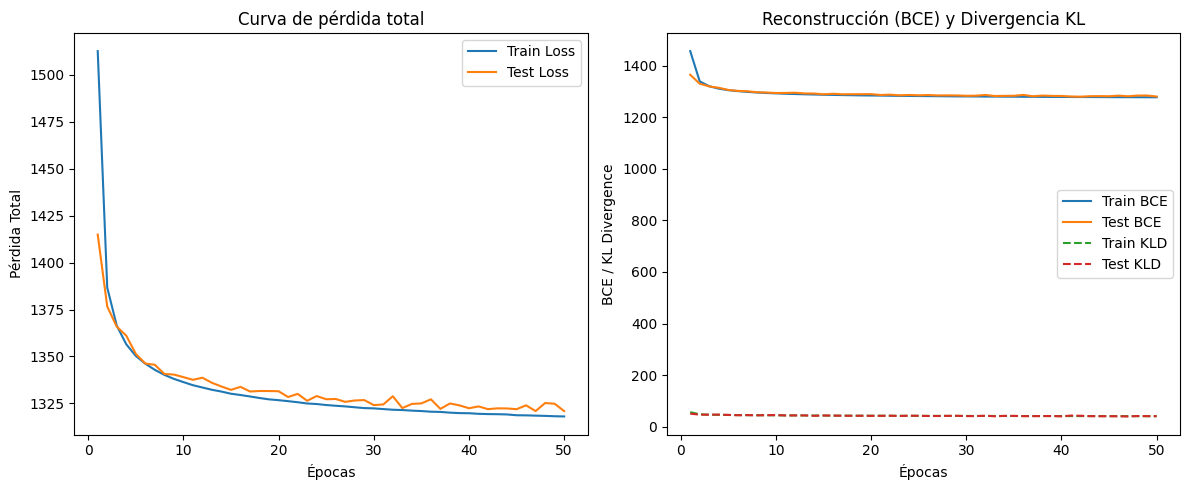

In [ ]:
# Graficar curvas de pérdida
epochs_range = range(1, epochs + 1)
train_loss, train_bce, train_kld = zip(*train_losses)
test_loss, test_bce, test_kld = zip(*test_losses)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, test_loss, label="Test Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida Total")
plt.legend()
plt.title("Curva de pérdida total")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bce, label="Train BCE")
plt.plot(epochs_range, test_bce, label="Test BCE")
plt.plot(epochs_range, train_kld, label="Train KLD", linestyle="dashed")
plt.plot(epochs_range, test_kld, label="Test KLD", linestyle="dashed")
plt.xlabel("Épocas")
plt.ylabel("BCE / KL Divergence")
plt.legend()
plt.title("Reconstrucción (BCE) y Divergencia KL")

plt.tight_layout()
plt.show()

Tiempo promedio por imagen: 0.0195 segundos
Uso de RAM: -0.63 MB
Uso de VRAM: -2.00 MB


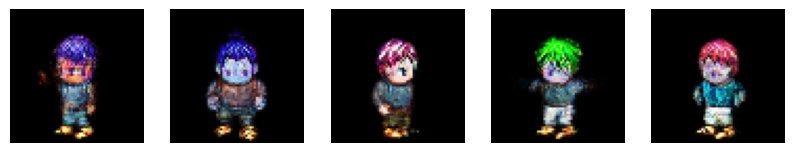

In [ ]:
import time
import psutil  # Para medir uso de CPU/RAM
import GPUtil  # Para medir uso de GPU

def get_gpu_memory():
    """Obtiene el uso actual de memoria de la GPU en MB."""
    gpus = GPUtil.getGPUs()
    if gpus:
        return gpus[0].memoryUsed
    return 0  # Si no hay GPU, devuelve 0

def generate_images_VAE(model, num_samples=5):
    model.eval()  # Modo evaluación
   
    # Medir uso inicial de recursos
    start_time = time.time()
    initial_ram = psutil.virtual_memory().used / (1024 ** 2)  # RAM en MB
    initial_gpu = get_gpu_memory()  # VRAM en MB

    with torch.no_grad():
        # Generar puntos aleatorios en el espacio latente
        z = torch.randn(num_samples, latent_size).to(device)

        # Decodificar para obtener imágenes
        generated_images = model.decode(z).cpu()
        generated_images = generated_images.view(-1, 3, 64, 64)  # RGB format

    # Medir uso final de recursos
    end_time = time.time()
    final_ram = psutil.virtual_memory().used / (1024 ** 2)  # RAM en MB
    final_gpu = get_gpu_memory()  # VRAM en MB

    # Calcular métricas
    execution_time = (end_time - start_time) / num_samples
    ram_used = final_ram - initial_ram
    gpu_used = final_gpu - initial_gpu

    print(f"Tiempo promedio por imagen: {execution_time:.4f} segundos")
    print(f"Uso de RAM: {ram_used:.2f} MB")
    print(f"Uso de VRAM: {gpu_used:.2f} MB")

    # Mostrar las imágenes con la clase
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = generated_images[i].permute(1, 2, 0).numpy()  # Reordenar ejes
        img = (img - img.min()) / (img.max() - img.min())  # Normalizar a [0,1]
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Llamar a la función para generar imágenes
generate_images_VAE(model, num_samples=5)



## CVAE

In [75]:

# Hiperparámetros
batch_size = 32
latent_size = 20
epochs = 50
feature_size = img_width * img_height * 3  # 64x64x3
num_classes = 72  # 3 acciones * 3 perfiles * 8 movimientos

# Función para generar one-hot encoding
def one_hot(labels, class_size):
    return F.one_hot(labels, class_size).float().to(device)

# Definición del modelo CVAE
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # Encoder
        self.fc1 = nn.Linear(feature_size + class_size, 512)
        self.fc21 = nn.Linear(512, latent_size)
        self.fc22 = nn.Linear(512, latent_size)

        # Decoder
        self.fc3 = nn.Linear(latent_size + class_size, 512)
        self.fc4 = nn.Linear(512, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c):
        inputs = torch.cat([x, c], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        inputs = torch.cat([z, c], 1)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, self.feature_size), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

# Crear el modelo
model = CVAE(feature_size, latent_size, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1: Train Loss: 1519.9908, BCE: 1469.0981, KLD: 50.8927
Epoch 1: Test Loss: 1391.9462, BCE: 1350.1518, KLD: 41.7944


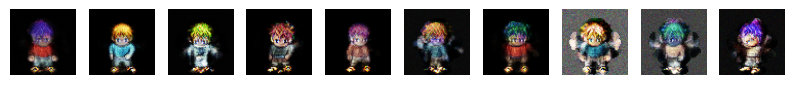

Epoch 2: Train Loss: 1365.9970, BCE: 1326.6220, KLD: 39.3750
Epoch 2: Test Loss: 1355.9296, BCE: 1319.5860, KLD: 36.3436


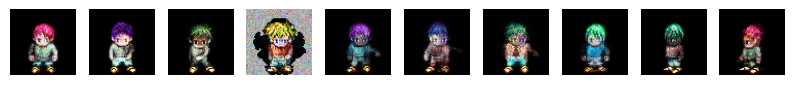

Epoch 3: Train Loss: 1341.5738, BCE: 1305.6900, KLD: 35.8838
Epoch 3: Test Loss: 1337.7260, BCE: 1303.3687, KLD: 34.3573


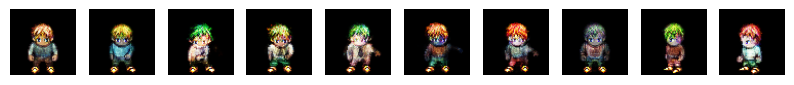

Epoch 4: Train Loss: 1328.7842, BCE: 1295.3501, KLD: 33.4342
Epoch 4: Test Loss: 1326.2342, BCE: 1293.8068, KLD: 32.4275


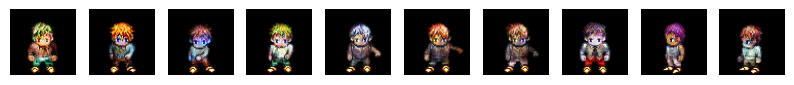

Epoch 5: Train Loss: 1319.9444, BCE: 1288.0512, KLD: 31.8933
Epoch 5: Test Loss: 1321.1015, BCE: 1291.0002, KLD: 30.1012


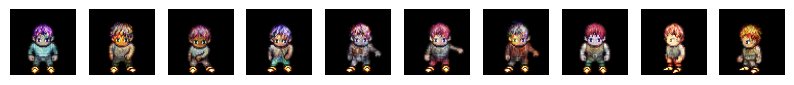

Epoch 6: Train Loss: 1313.6092, BCE: 1282.8837, KLD: 30.7254
Epoch 6: Test Loss: 1314.5235, BCE: 1284.0057, KLD: 30.5178


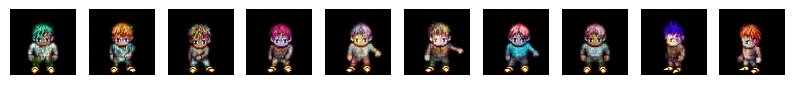

Epoch 7: Train Loss: 1308.6350, BCE: 1278.9628, KLD: 29.6722
Epoch 7: Test Loss: 1309.5179, BCE: 1280.4358, KLD: 29.0822


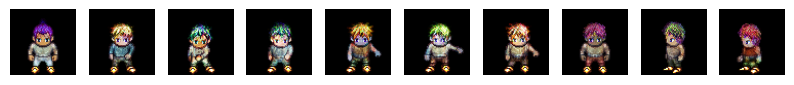

Epoch 8: Train Loss: 1304.6302, BCE: 1275.9637, KLD: 28.6665
Epoch 8: Test Loss: 1306.4185, BCE: 1277.4495, KLD: 28.9690


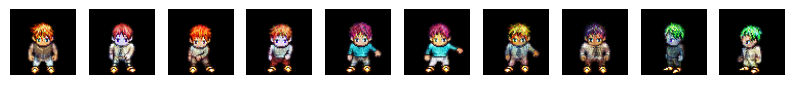

Epoch 9: Train Loss: 1301.2882, BCE: 1273.5159, KLD: 27.7723
Epoch 9: Test Loss: 1303.7387, BCE: 1276.7619, KLD: 26.9768


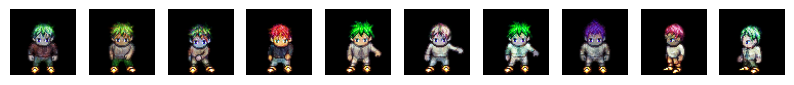

Epoch 10: Train Loss: 1298.2918, BCE: 1271.4827, KLD: 26.8092
Epoch 10: Test Loss: 1301.3455, BCE: 1275.2509, KLD: 26.0946


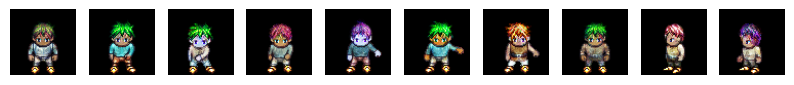

Epoch 11: Train Loss: 1295.3854, BCE: 1269.7036, KLD: 25.6819
Epoch 11: Test Loss: 1297.2845, BCE: 1272.6843, KLD: 24.6003


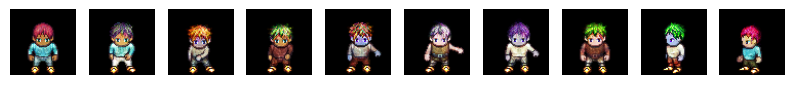

Epoch 12: Train Loss: 1292.7404, BCE: 1267.9395, KLD: 24.8009
Epoch 12: Test Loss: 1294.7488, BCE: 1270.3545, KLD: 24.3943


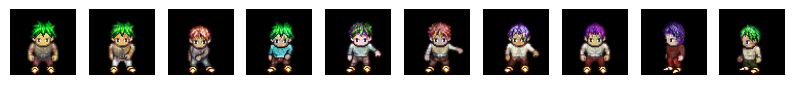

Epoch 13: Train Loss: 1290.7257, BCE: 1266.4230, KLD: 24.3026
Epoch 13: Test Loss: 1292.8902, BCE: 1269.4210, KLD: 23.4692


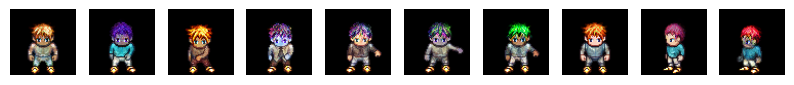

Epoch 14: Train Loss: 1289.2627, BCE: 1265.2877, KLD: 23.9750
Epoch 14: Test Loss: 1292.8392, BCE: 1268.3366, KLD: 24.5026


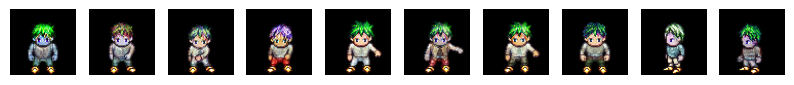

Epoch 15: Train Loss: 1287.8546, BCE: 1264.2231, KLD: 23.6315
Epoch 15: Test Loss: 1290.4073, BCE: 1266.9662, KLD: 23.4411


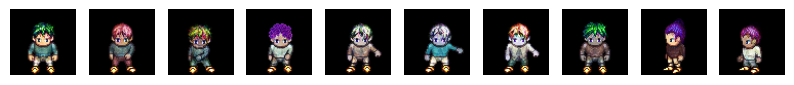

Epoch 16: Train Loss: 1286.8139, BCE: 1263.3525, KLD: 23.4614
Epoch 16: Test Loss: 1289.1467, BCE: 1265.7267, KLD: 23.4200


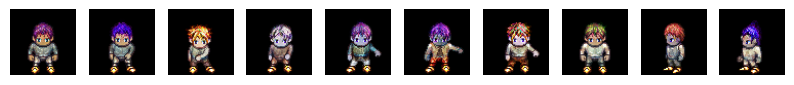

Epoch 17: Train Loss: 1285.9843, BCE: 1262.6643, KLD: 23.3200
Epoch 17: Test Loss: 1288.8981, BCE: 1263.9743, KLD: 24.9238


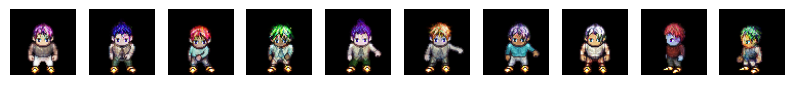

Epoch 18: Train Loss: 1285.2992, BCE: 1262.1256, KLD: 23.1736
Epoch 18: Test Loss: 1288.2935, BCE: 1266.1227, KLD: 22.1709


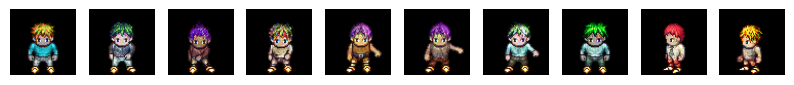

Epoch 19: Train Loss: 1284.6503, BCE: 1261.5990, KLD: 23.0513
Epoch 19: Test Loss: 1288.0759, BCE: 1264.3365, KLD: 23.7393


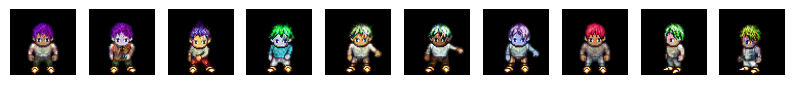

Epoch 20: Train Loss: 1284.1592, BCE: 1261.2033, KLD: 22.9560
Epoch 20: Test Loss: 1288.4249, BCE: 1265.6983, KLD: 22.7266


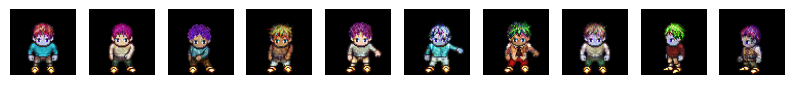

Epoch 21: Train Loss: 1283.7735, BCE: 1260.9017, KLD: 22.8718
Epoch 21: Test Loss: 1285.8113, BCE: 1262.5688, KLD: 23.2424


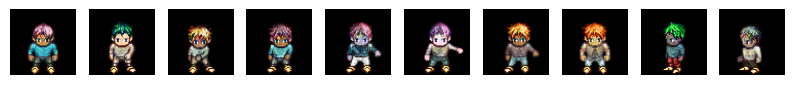

Epoch 22: Train Loss: 1283.1893, BCE: 1260.4640, KLD: 22.7253
Epoch 22: Test Loss: 1287.8804, BCE: 1266.2902, KLD: 21.5902


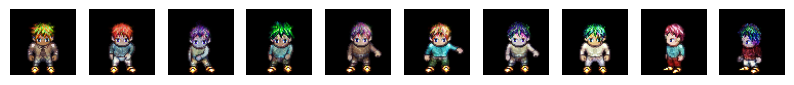

Epoch 23: Train Loss: 1282.8253, BCE: 1260.1789, KLD: 22.6464
Epoch 23: Test Loss: 1285.0093, BCE: 1263.3529, KLD: 21.6564


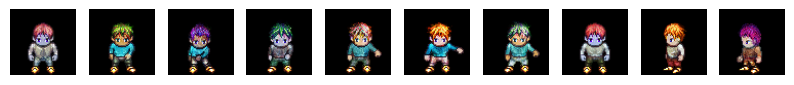

Epoch 24: Train Loss: 1282.4154, BCE: 1259.8830, KLD: 22.5325
Epoch 24: Test Loss: 1286.2697, BCE: 1263.2304, KLD: 23.0393


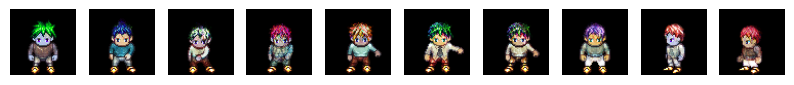

Epoch 25: Train Loss: 1282.0392, BCE: 1259.6131, KLD: 22.4260
Epoch 25: Test Loss: 1285.0312, BCE: 1263.4858, KLD: 21.5455


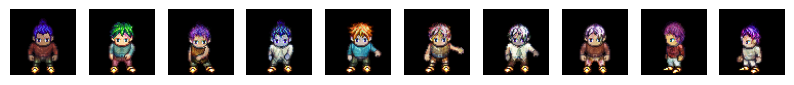

Epoch 26: Train Loss: 1281.7583, BCE: 1259.4199, KLD: 22.3383
Epoch 26: Test Loss: 1284.7246, BCE: 1262.2402, KLD: 22.4844


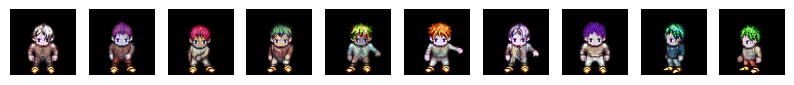

Epoch 27: Train Loss: 1281.4096, BCE: 1259.1778, KLD: 22.2319
Epoch 27: Test Loss: 1284.0076, BCE: 1262.0347, KLD: 21.9729


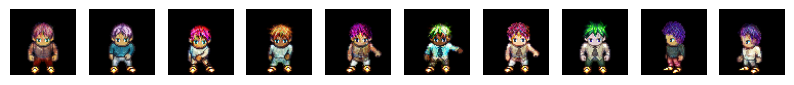

Epoch 28: Train Loss: 1281.0546, BCE: 1258.9623, KLD: 22.0923
Epoch 28: Test Loss: 1283.4849, BCE: 1261.3076, KLD: 22.1773


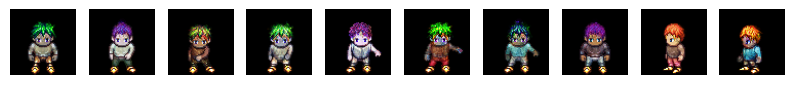

Epoch 29: Train Loss: 1280.7760, BCE: 1258.7820, KLD: 21.9940
Epoch 29: Test Loss: 1282.8904, BCE: 1261.2402, KLD: 21.6502


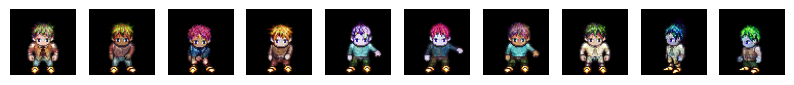

Epoch 30: Train Loss: 1280.4711, BCE: 1258.5989, KLD: 21.8723
Epoch 30: Test Loss: 1283.2632, BCE: 1262.2440, KLD: 21.0192


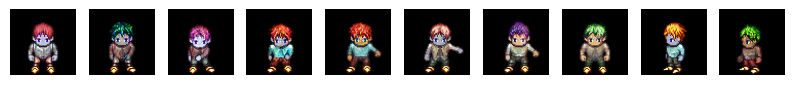

Epoch 31: Train Loss: 1280.1846, BCE: 1258.4090, KLD: 21.7756
Epoch 31: Test Loss: 1284.1197, BCE: 1261.6766, KLD: 22.4430


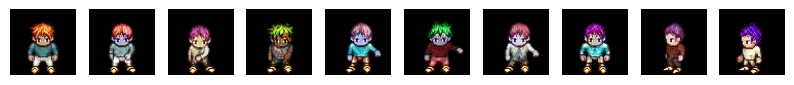

Epoch 32: Train Loss: 1279.9373, BCE: 1258.2551, KLD: 21.6823
Epoch 32: Test Loss: 1283.4045, BCE: 1262.3848, KLD: 21.0197


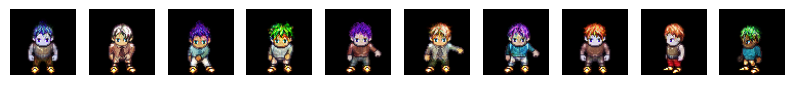

Epoch 33: Train Loss: 1279.7378, BCE: 1258.1311, KLD: 21.6068
Epoch 33: Test Loss: 1282.8434, BCE: 1261.2968, KLD: 21.5465


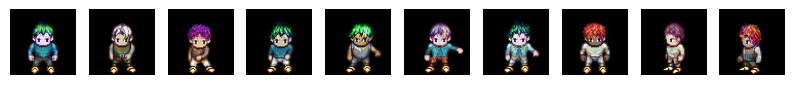

Epoch 34: Train Loss: 1279.4062, BCE: 1257.9236, KLD: 21.4826
Epoch 34: Test Loss: 1282.0379, BCE: 1261.6063, KLD: 20.4317


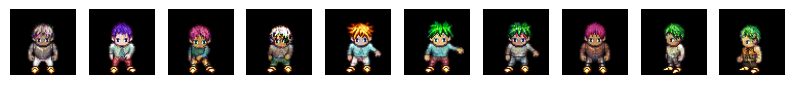

Epoch 35: Train Loss: 1279.2473, BCE: 1257.8545, KLD: 21.3928
Epoch 35: Test Loss: 1283.5584, BCE: 1261.1977, KLD: 22.3608


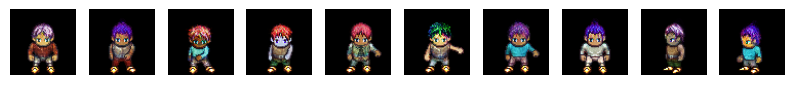

Epoch 36: Train Loss: 1278.9753, BCE: 1257.6515, KLD: 21.3238
Epoch 36: Test Loss: 1282.7904, BCE: 1262.4057, KLD: 20.3847


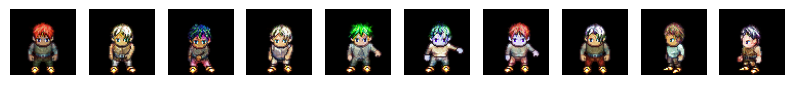

Epoch 37: Train Loss: 1278.8364, BCE: 1257.5906, KLD: 21.2458
Epoch 37: Test Loss: 1282.6374, BCE: 1260.8013, KLD: 21.8362


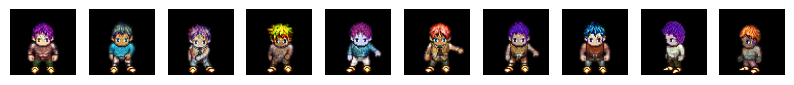

Epoch 38: Train Loss: 1278.5326, BCE: 1257.3710, KLD: 21.1615
Epoch 38: Test Loss: 1281.9522, BCE: 1261.7390, KLD: 20.2132


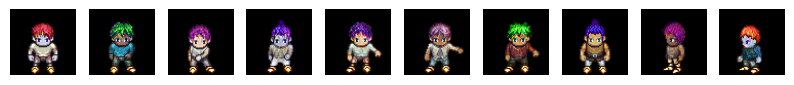

Epoch 39: Train Loss: 1278.3983, BCE: 1257.3066, KLD: 21.0916
Epoch 39: Test Loss: 1282.4930, BCE: 1261.1946, KLD: 21.2984


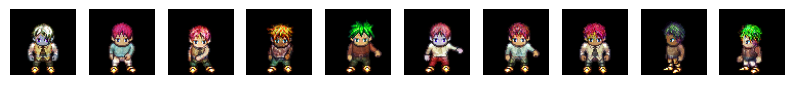

Epoch 40: Train Loss: 1278.2826, BCE: 1257.2249, KLD: 21.0577
Epoch 40: Test Loss: 1280.6737, BCE: 1259.8662, KLD: 20.8075


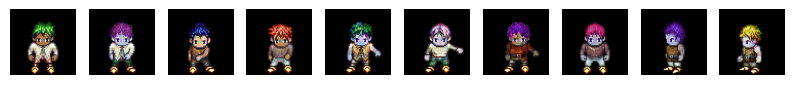

Epoch 41: Train Loss: 1277.9652, BCE: 1257.0398, KLD: 20.9254
Epoch 41: Test Loss: 1280.8728, BCE: 1260.4199, KLD: 20.4529


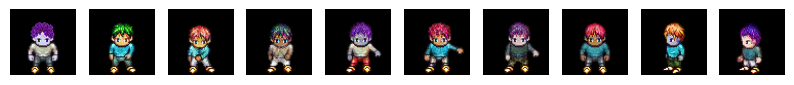

Epoch 42: Train Loss: 1277.8419, BCE: 1256.9477, KLD: 20.8943
Epoch 42: Test Loss: 1281.9670, BCE: 1261.4671, KLD: 20.5000


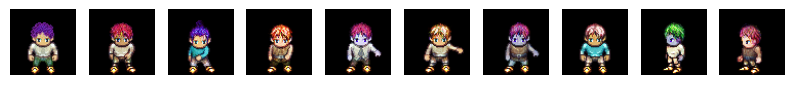

Epoch 43: Train Loss: 1277.7317, BCE: 1256.8945, KLD: 20.8372
Epoch 43: Test Loss: 1280.5173, BCE: 1260.2420, KLD: 20.2753


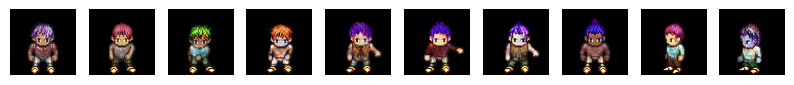

Epoch 44: Train Loss: 1277.6143, BCE: 1256.8148, KLD: 20.7994
Epoch 44: Test Loss: 1281.8081, BCE: 1261.2377, KLD: 20.5703


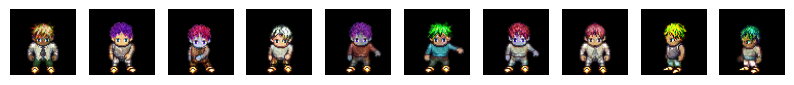

Epoch 45: Train Loss: 1277.4502, BCE: 1256.6930, KLD: 20.7572
Epoch 45: Test Loss: 1281.0802, BCE: 1260.6952, KLD: 20.3851


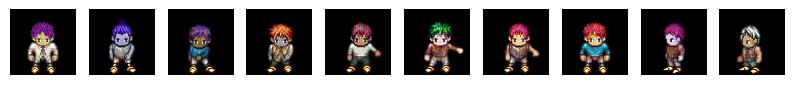

Epoch 46: Train Loss: 1277.2978, BCE: 1256.5988, KLD: 20.6990
Epoch 46: Test Loss: 1280.0366, BCE: 1260.3345, KLD: 19.7020


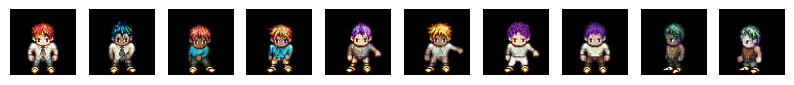

Epoch 47: Train Loss: 1277.1679, BCE: 1256.5261, KLD: 20.6418
Epoch 47: Test Loss: 1279.6172, BCE: 1259.4177, KLD: 20.1995


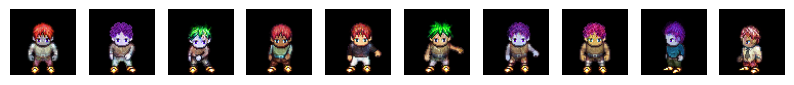

Epoch 48: Train Loss: 1277.1043, BCE: 1256.4754, KLD: 20.6289
Epoch 48: Test Loss: 1281.3261, BCE: 1259.6251, KLD: 21.7010


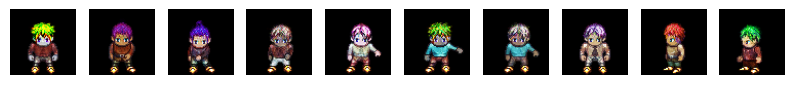

Epoch 49: Train Loss: 1276.9187, BCE: 1256.3848, KLD: 20.5339
Epoch 49: Test Loss: 1280.5275, BCE: 1259.6898, KLD: 20.8378


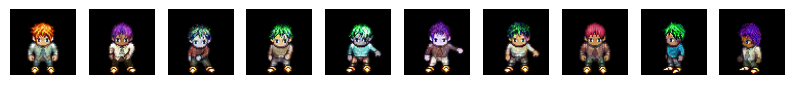

Epoch 50: Train Loss: 1276.8695, BCE: 1256.2926, KLD: 20.5769
Epoch 50: Test Loss: 1279.4117, BCE: 1258.8365, KLD: 20.5753


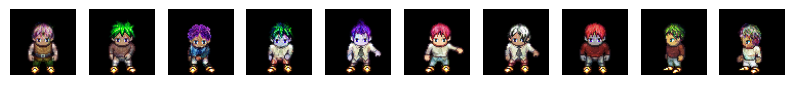

In [76]:


# Almacenar las pérdidas
train_losses = []
test_losses = []

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, feature_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # Divergencia KL
    return BCE + KLD, BCE, KLD

def train(epoch):
    model.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot(labels, num_classes)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    train_losses.append((avg_loss, avg_bce, avg_kld))
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")

def test(epoch):
    model.eval()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    with torch.no_grad():
        i=0
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            labels = one_hot(labels, num_classes)

            recon_batch, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()

    avg_loss = total_loss / len(test_loader.dataset)
    avg_bce = total_bce / len(test_loader.dataset)
    avg_kld = total_kld / len(test_loader.dataset)

    test_losses.append((avg_loss, avg_bce, avg_kld))
    print(f"Epoch {epoch}: Test Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")

# Entrenamiento
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    #Dibujar entre epocas
    with torch.no_grad():
        c = torch.eye(num_classes, num_classes).to(device)[:10]
        sample = torch.randn(10, latent_size).to(device)
        sample = model.decode(sample, c).cpu()
        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for j in range(10):
            axes[j].imshow(sample.view(10, 3, 64, 64)[j].permute(1, 2, 0).cpu().numpy())
            axes[j].axis("off")
        plt.show()




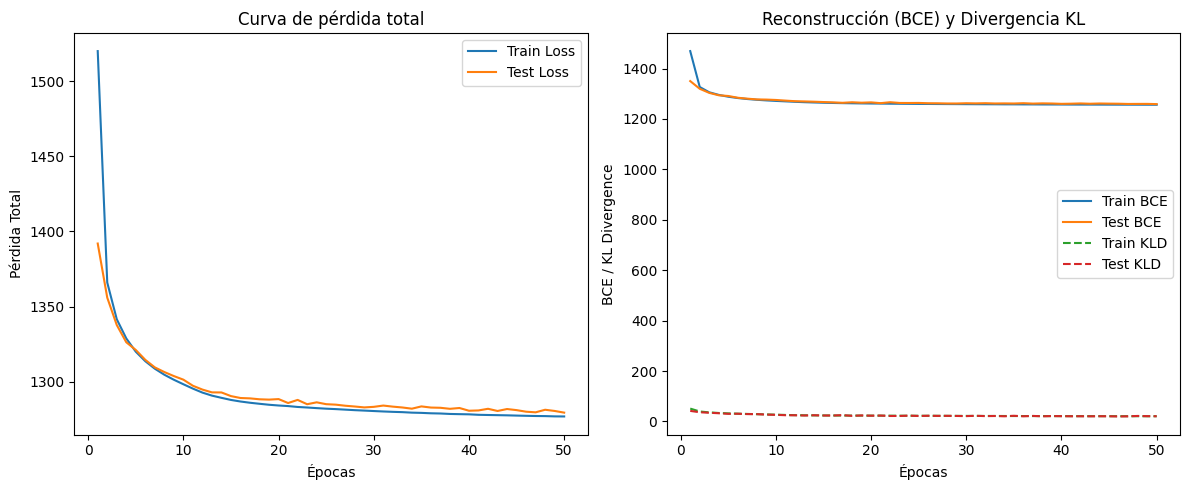

In [77]:
# Graficar curvas de pérdida
epochs_range = range(1, epochs + 1)
train_loss, train_bce, train_kld = zip(*train_losses)
test_loss, test_bce, test_kld = zip(*test_losses)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, test_loss, label="Test Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida Total")
plt.legend()
plt.title("Curva de pérdida total")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bce, label="Train BCE")
plt.plot(epochs_range, test_bce, label="Test BCE")
plt.plot(epochs_range, train_kld, label="Train KLD", linestyle="dashed")
plt.plot(epochs_range, test_kld, label="Test KLD", linestyle="dashed")
plt.xlabel("Épocas")
plt.ylabel("BCE / KL Divergence")
plt.legend()
plt.title("Reconstrucción (BCE) y Divergencia KL")

plt.tight_layout()
plt.show()

tensor([21, 24, 53, 43, 19])
Tiempo promedio por imagen: 0.0198 segundos
Uso de RAM: -0.89 MB
Uso de VRAM: 6.00 MB


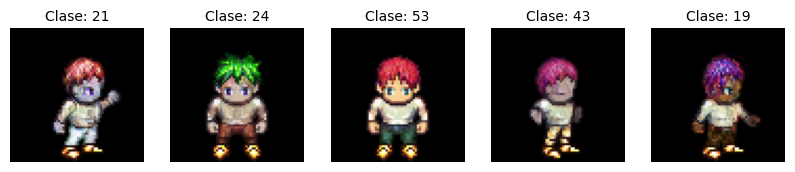

tensor([5, 5, 5, 5, 5])
Tiempo promedio por imagen: 0.0170 segundos
Uso de RAM: -0.18 MB
Uso de VRAM: 4.00 MB


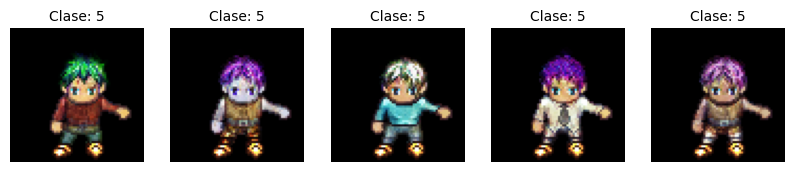

tensor([21, 21, 21, 21, 21])
Tiempo promedio por imagen: 0.0181 segundos
Uso de RAM: -0.16 MB
Uso de VRAM: 2.00 MB


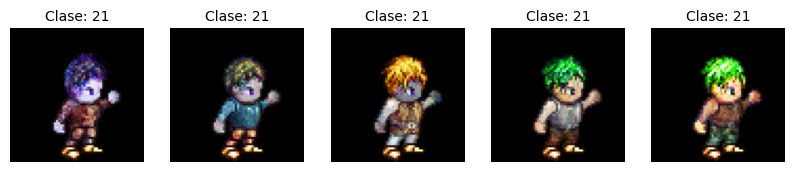

tensor([13, 13, 13, 13, 13])
Tiempo promedio por imagen: 0.0162 segundos
Uso de RAM: 0.24 MB
Uso de VRAM: 5.00 MB


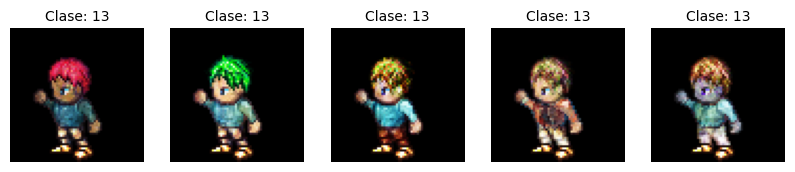

tensor([29, 29, 29, 29, 29])
Tiempo promedio por imagen: 0.0183 segundos
Uso de RAM: 0.03 MB
Uso de VRAM: 1.00 MB


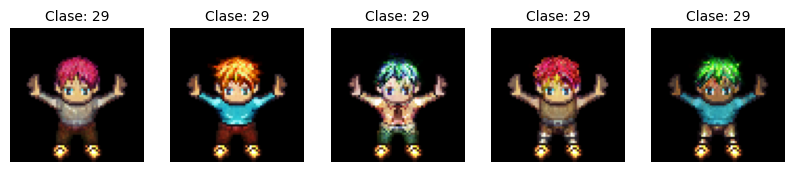

tensor([45, 45, 45, 45, 45])
Tiempo promedio por imagen: 0.0166 segundos
Uso de RAM: 0.20 MB
Uso de VRAM: -2.00 MB


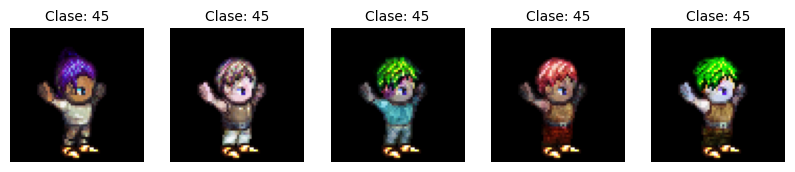

tensor([37, 37, 37, 37, 37])
Tiempo promedio por imagen: 0.0194 segundos
Uso de RAM: -0.01 MB
Uso de VRAM: 0.00 MB


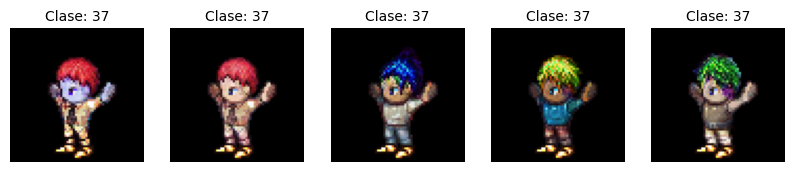

tensor([53, 53, 53, 53, 53])
Tiempo promedio por imagen: 0.0170 segundos
Uso de RAM: -0.02 MB
Uso de VRAM: 0.00 MB


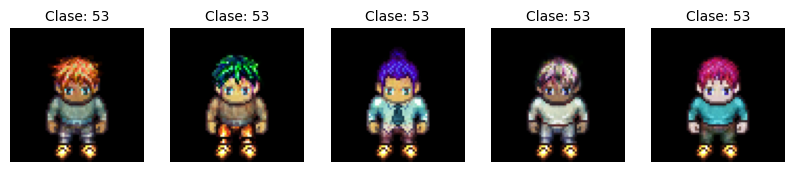

tensor([69, 69, 69, 69, 69])
Tiempo promedio por imagen: 0.0183 segundos
Uso de RAM: -0.76 MB
Uso de VRAM: 0.00 MB


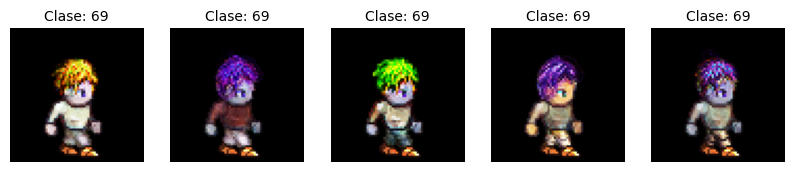

tensor([61, 61, 61, 61, 61])
Tiempo promedio por imagen: 0.0173 segundos
Uso de RAM: 0.93 MB
Uso de VRAM: 0.00 MB


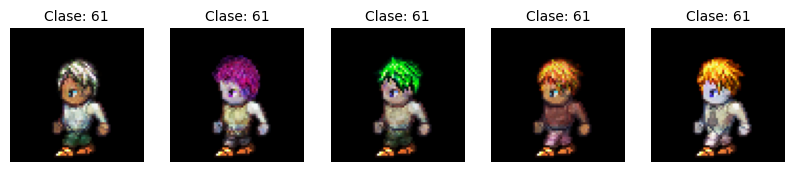

In [94]:
import time
import psutil  # Para medir uso de CPU/RAM
import GPUtil  # Para medir uso de GPU

def get_gpu_memory():
    """Obtiene el uso actual de memoria de la GPU en MB."""
    gpus = GPUtil.getGPUs()
    if gpus:
        return gpus[0].memoryUsed
    return 0  # Si no hay GPU, devuelve 0

def generate_images(model, num_samples=5,accion=None,perfil=None,movimiento=None):
    model.eval()  # Modo evaluación
   
    # Medir uso inicial de recursos
    start_time = time.time()
    initial_ram = psutil.virtual_memory().used / (1024 ** 2)  # RAM en MB
    initial_gpu = get_gpu_memory()  # VRAM en MB

    with torch.no_grad():
        # Crear etiquetas aleatorias en one-hot
        if not None in [accion,perfil,movimiento]:
            perfil_grupo=['front','left','right']
            accion_grupo=['slash','spellcard','walk']
            perfiln=perfil_grupo.index(perfil)
            accionn=accion_grupo.index(accion)
            clases_list=[(accionn*3*8)+(perfiln*8)+movimiento for _ in range(num_samples)]
            clases = torch.tensor(clases_list, dtype=torch.long)
            print(clases)
        else:
            clases = torch.randint(0, num_classes, (num_samples,))
            print(clases)
        c = torch.zeros(num_samples, num_classes)
        c[range(num_samples), clases] = 1
        c = c.to(device)

        # Generar puntos aleatorios en el espacio latente
        z = torch.randn(num_samples, latent_size).to(device)

        # Decodificar para obtener imágenes
        generated_images = model.decode(z, c).cpu()
        generated_images = generated_images.view(-1, 3, 64, 64)  # RGB format

    # Medir uso final de recursos
    end_time = time.time()
    final_ram = psutil.virtual_memory().used / (1024 ** 2)  # RAM en MB
    final_gpu = get_gpu_memory()  # VRAM en MB

    # Calcular métricas
    execution_time = (end_time - start_time) / num_samples
    ram_used = final_ram - initial_ram
    gpu_used = final_gpu - initial_gpu

    print(f"Tiempo promedio por imagen: {execution_time:.4f} segundos")
    print(f"Uso de RAM: {ram_used:.2f} MB")
    print(f"Uso de VRAM: {gpu_used:.2f} MB")

    # Mostrar las imágenes con la clase
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = generated_images[i].permute(1, 2, 0).numpy()  # Reordenar ejes
        img = (img - img.min()) / (img.max() - img.min())  # Normalizar a [0,1]
        class_label = f"Clase: {clases[i].item()}"  # Nombre de la clase

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(class_label, fontsize=10)

    plt.show()

# Llamar a la función para generar imágenes
generate_images(model, num_samples=5)
generate_images(model, num_samples=5,perfil='front',accion='slash',movimiento=5)
generate_images(model, num_samples=5,perfil='right',accion='slash',movimiento=5)
generate_images(model, num_samples=5,perfil='left',accion='slash',movimiento=5)
generate_images(model, num_samples=5,perfil='front',accion='spellcard',movimiento=5)
generate_images(model, num_samples=5,perfil='right',accion='spellcard',movimiento=5)
generate_images(model, num_samples=5,perfil='left',accion='spellcard',movimiento=5)
generate_images(model, num_samples=5,perfil='front',accion='walk',movimiento=5)
generate_images(model, num_samples=5,perfil='right',accion='walk',movimiento=5)
generate_images(model, num_samples=5,perfil='left',accion='walk',movimiento=5)


## HVAE

In [ ]:
# Hiperparámetros
batch_size = 32
latent_size = 20
latent_size2 = latent_size
epochs = 50
feature_size = img_width * img_height * 3  # 64x64x3

# Definición del modelo HVAE
class HVAE(nn.Module):
    def __init__(self, feature_size, latent_size):
        super(HVAE, self).__init__()
        self.feature_size = feature_size
        self.latent_size = latent_size

        # Primera capa latente (z1) -> Representa información general
        self.fc1 = nn.Linear(feature_size, 512)
        self.fc21 = nn.Linear(512, latent_size // 2)  # Mu de z1
        self.fc22 = nn.Linear(512, latent_size // 2)  # LogVar de z1

        # Segunda capa latente (z2) -> Representa detalles más finos
        self.fc3 = nn.Linear(latent_size // 2, 256)
        self.fc31 = nn.Linear(256, latent_size // 2)  # Mu de z2
        self.fc32 = nn.Linear(256, latent_size // 2)  # LogVar de z2

        # Decodificador
        self.fc4 = nn.Linear(latent_size // 2, 256)  # Decodifica z2
        self.fc5 = nn.Linear(256, latent_size // 2)  # Reconstrucción de z1
        self.fc6 = nn.Linear(latent_size, 512)  # Decodifica z1 + z1_rec
        self.fc7 = nn.Linear(512, feature_size)  # Genera la imagen final

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """ Codifica la imagen en z1 y luego en z2 """
        x = x.view(-1, self.feature_size)
        h1 = self.elu(self.fc1(x))
        mu1, logvar1 = self.fc21(h1), self.fc22(h1)
        z1 = self.reparameterize(mu1, logvar1)

        h3 = self.elu(self.fc3(z1))
        mu2, logvar2 = self.fc31(h3), self.fc32(h3)
        z2 = self.reparameterize(mu2, logvar2)

        return z1, mu1, logvar1, z2, mu2, logvar2

    def reparameterize(self, mu, logvar):
        """ Muestreo usando la reparametrización de Kingma y Welling """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z1, z2):
        """ Decodifica la imagen desde las variables latentes """
        h4 = self.elu(self.fc4(z2))
        z1_decoded = self.fc5(h4)  # Reconstrucción de z1

        z_concat = torch.cat([z1, z1_decoded], dim=1)  # Concatenar z1 original + reconstruido

        h6 = self.elu(self.fc6(z_concat))
        return self.sigmoid(self.fc7(h6))  # Imagen reconstruida

    def forward(self, x):
        """ Pasa la imagen por el modelo y devuelve la reconstrucción """
        z1, mu1, logvar1, z2, mu2, logvar2 = self.encode(x)
        recon_x = self.decode(z1, z2)
        return recon_x, mu1, logvar1, mu2, logvar2


# Crear el modelo
model = HVAE(feature_size, latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1: Train Loss: 1553.5896, BCE: 1513.6502, KLD1: 38.0133, KLD2: 1.9260
Epoch 1: Test Loss: 1445.0237, BCE: 1408.8455, KLD1: 34.6094, KLD2: 1.5688


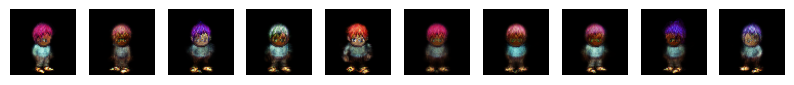

Epoch 2: Train Loss: 1415.9593, BCE: 1379.1288, KLD1: 34.9583, KLD2: 1.8722
Epoch 2: Test Loss: 1399.8576, BCE: 1363.0044, KLD1: 34.7267, KLD2: 2.1265


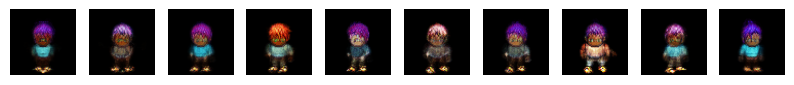

Epoch 3: Train Loss: 1386.6993, BCE: 1350.8926, KLD1: 33.7043, KLD2: 2.1024
Epoch 3: Test Loss: 1382.1294, BCE: 1346.9040, KLD1: 33.0658, KLD2: 2.1596


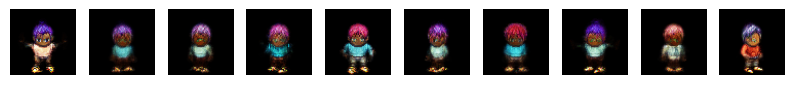

Epoch 4: Train Loss: 1372.4997, BCE: 1337.5731, KLD1: 32.7522, KLD2: 2.1744
Epoch 4: Test Loss: 1372.3343, BCE: 1337.3214, KLD1: 32.8027, KLD2: 2.2101


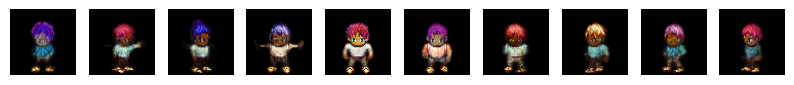

Epoch 5: Train Loss: 1363.7339, BCE: 1329.4752, KLD1: 32.0515, KLD2: 2.2073
Epoch 5: Test Loss: 1363.9329, BCE: 1330.2811, KLD1: 31.4006, KLD2: 2.2512


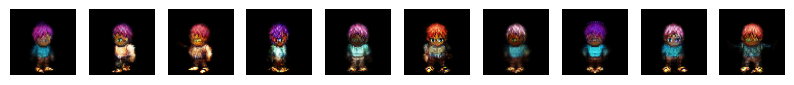

Epoch 6: Train Loss: 1357.5186, BCE: 1323.6267, KLD1: 31.6689, KLD2: 2.2231
Epoch 6: Test Loss: 1357.8740, BCE: 1323.4262, KLD1: 32.2648, KLD2: 2.1830


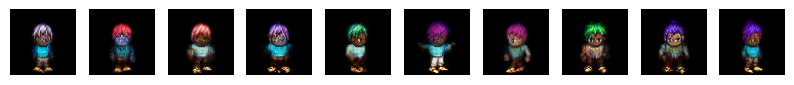

Epoch 7: Train Loss: 1352.5711, BCE: 1318.9627, KLD1: 31.3731, KLD2: 2.2353
Epoch 7: Test Loss: 1353.8464, BCE: 1321.2969, KLD1: 30.3058, KLD2: 2.2436


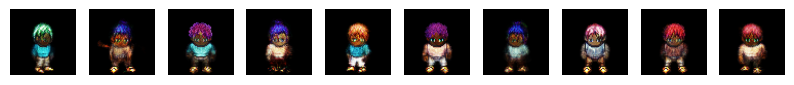

Epoch 8: Train Loss: 1348.7364, BCE: 1315.2913, KLD1: 31.1756, KLD2: 2.2695
Epoch 8: Test Loss: 1349.7804, BCE: 1315.6898, KLD1: 31.8298, KLD2: 2.2609


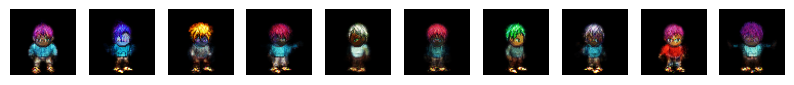

Epoch 9: Train Loss: 1345.0032, BCE: 1311.6440, KLD1: 31.0636, KLD2: 2.2956
Epoch 9: Test Loss: 1346.3717, BCE: 1312.7945, KLD1: 31.2337, KLD2: 2.3435


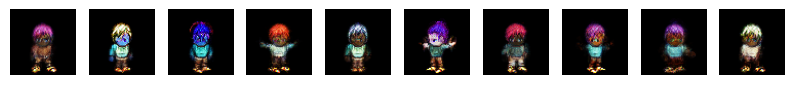

Epoch 10: Train Loss: 1341.9950, BCE: 1308.7189, KLD1: 30.9631, KLD2: 2.3131
Epoch 10: Test Loss: 1346.9067, BCE: 1314.2114, KLD1: 30.3734, KLD2: 2.3219


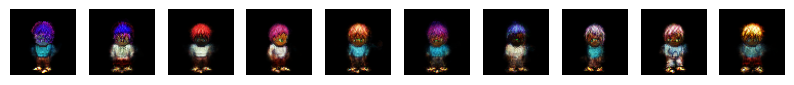

Epoch 11: Train Loss: 1339.5141, BCE: 1306.2698, KLD1: 30.8990, KLD2: 2.3453
Epoch 11: Test Loss: 1340.3564, BCE: 1307.2986, KLD1: 30.7872, KLD2: 2.2706


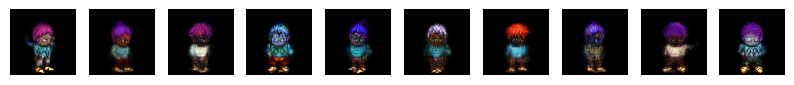

Epoch 12: Train Loss: 1337.5378, BCE: 1304.3396, KLD1: 30.8318, KLD2: 2.3664
Epoch 12: Test Loss: 1341.8989, BCE: 1307.7239, KLD1: 31.7771, KLD2: 2.3979


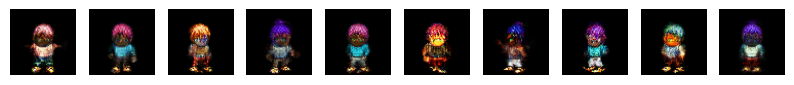

Epoch 13: Train Loss: 1335.4287, BCE: 1302.3036, KLD1: 30.7397, KLD2: 2.3854
Epoch 13: Test Loss: 1337.1965, BCE: 1303.7780, KLD1: 30.9587, KLD2: 2.4598


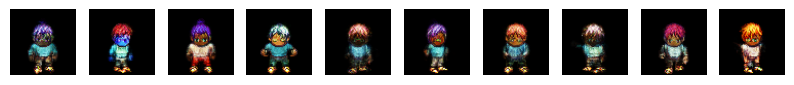

Epoch 14: Train Loss: 1333.7056, BCE: 1300.6314, KLD1: 30.6753, KLD2: 2.3990
Epoch 14: Test Loss: 1333.7644, BCE: 1300.5427, KLD1: 30.8654, KLD2: 2.3563


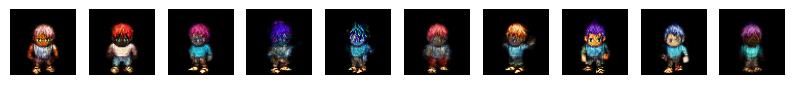

Epoch 15: Train Loss: 1332.4316, BCE: 1299.4466, KLD1: 30.5797, KLD2: 2.4053
Epoch 15: Test Loss: 1339.7201, BCE: 1306.5148, KLD1: 30.8143, KLD2: 2.3910


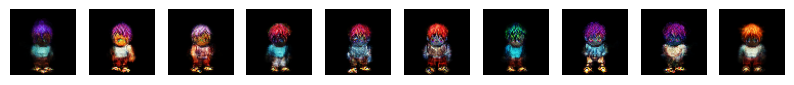

Epoch 16: Train Loss: 1330.8306, BCE: 1297.8650, KLD1: 30.5511, KLD2: 2.4144
Epoch 16: Test Loss: 1339.3871, BCE: 1306.7535, KLD1: 30.1856, KLD2: 2.4479


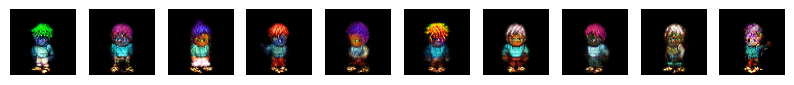

Epoch 17: Train Loss: 1329.7385, BCE: 1296.8121, KLD1: 30.4971, KLD2: 2.4293
Epoch 17: Test Loss: 1332.8934, BCE: 1299.8126, KLD1: 30.6573, KLD2: 2.4235


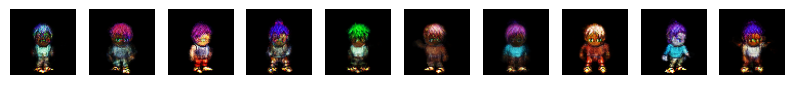

Epoch 18: Train Loss: 1328.5311, BCE: 1295.6406, KLD1: 30.4650, KLD2: 2.4255
Epoch 18: Test Loss: 1336.1971, BCE: 1302.5919, KLD1: 31.1897, KLD2: 2.4155


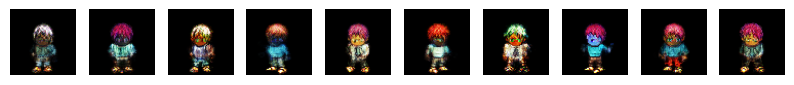

Epoch 19: Train Loss: 1327.5398, BCE: 1294.6950, KLD1: 30.4116, KLD2: 2.4332
Epoch 19: Test Loss: 1329.7988, BCE: 1296.8299, KLD1: 30.5043, KLD2: 2.4646


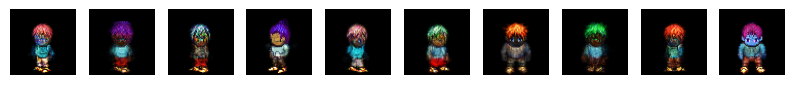

Epoch 20: Train Loss: 1326.5368, BCE: 1293.7562, KLD1: 30.3459, KLD2: 2.4348
Epoch 20: Test Loss: 1329.6984, BCE: 1296.5327, KLD1: 30.7539, KLD2: 2.4118


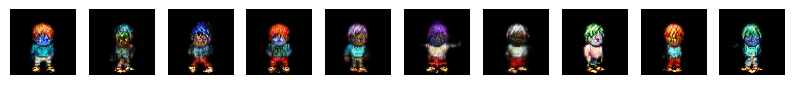

Epoch 21: Train Loss: 1325.7248, BCE: 1292.9452, KLD1: 30.3371, KLD2: 2.4425
Epoch 21: Test Loss: 1334.9738, BCE: 1301.4061, KLD1: 31.1026, KLD2: 2.4651


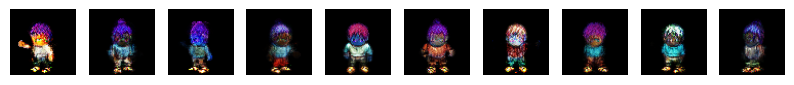

Epoch 22: Train Loss: 1324.9940, BCE: 1292.2592, KLD1: 30.2872, KLD2: 2.4476
Epoch 22: Test Loss: 1328.0364, BCE: 1295.2702, KLD1: 30.3277, KLD2: 2.4385


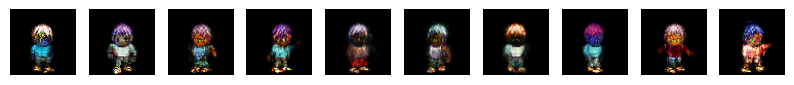

Epoch 23: Train Loss: 1324.2587, BCE: 1291.5857, KLD1: 30.2222, KLD2: 2.4508
Epoch 23: Test Loss: 1331.0533, BCE: 1297.7065, KLD1: 30.9036, KLD2: 2.4432


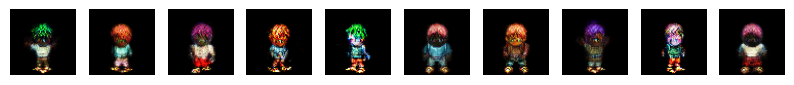

Epoch 24: Train Loss: 1323.5289, BCE: 1290.8788, KLD1: 30.1949, KLD2: 2.4552
Epoch 24: Test Loss: 1326.7024, BCE: 1293.8619, KLD1: 30.4452, KLD2: 2.3953


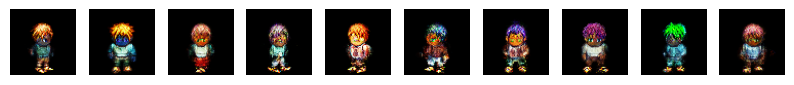

Epoch 25: Train Loss: 1322.8495, BCE: 1290.2461, KLD1: 30.1433, KLD2: 2.4601
Epoch 25: Test Loss: 1326.4516, BCE: 1293.9657, KLD1: 30.0579, KLD2: 2.4280


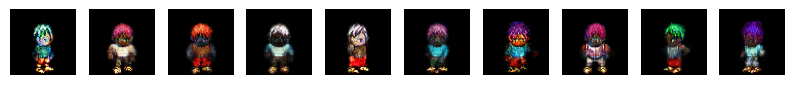

Epoch 26: Train Loss: 1322.5385, BCE: 1289.9454, KLD1: 30.1290, KLD2: 2.4642
Epoch 26: Test Loss: 1324.8789, BCE: 1291.4934, KLD1: 30.9363, KLD2: 2.4492


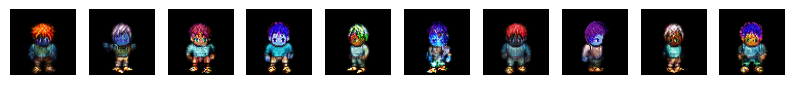

Epoch 27: Train Loss: 1321.9008, BCE: 1289.3220, KLD1: 30.1122, KLD2: 2.4665
Epoch 27: Test Loss: 1324.1043, BCE: 1291.7392, KLD1: 29.8970, KLD2: 2.4681


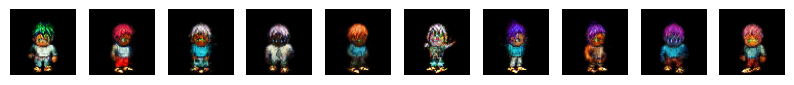

Epoch 28: Train Loss: 1321.4197, BCE: 1288.8884, KLD1: 30.0754, KLD2: 2.4559
Epoch 28: Test Loss: 1326.4632, BCE: 1294.2194, KLD1: 29.8133, KLD2: 2.4305


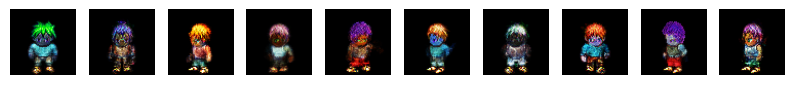

Epoch 29: Train Loss: 1320.9663, BCE: 1288.4679, KLD1: 30.0289, KLD2: 2.4695
Epoch 29: Test Loss: 1325.2852, BCE: 1292.4548, KLD1: 30.3701, KLD2: 2.4604


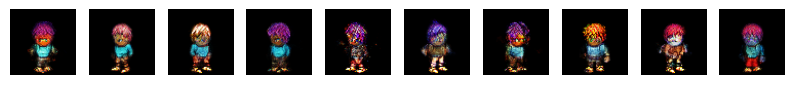

Epoch 30: Train Loss: 1320.3860, BCE: 1287.9255, KLD1: 29.9938, KLD2: 2.4667
Epoch 30: Test Loss: 1324.9700, BCE: 1293.3103, KLD1: 29.2083, KLD2: 2.4514


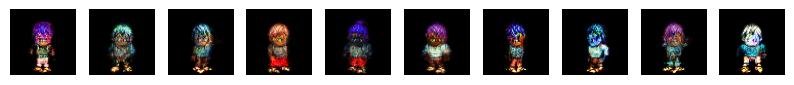

Epoch 31: Train Loss: 1319.9393, BCE: 1287.5127, KLD1: 29.9598, KLD2: 2.4668
Epoch 31: Test Loss: 1322.0850, BCE: 1289.3497, KLD1: 30.3096, KLD2: 2.4257


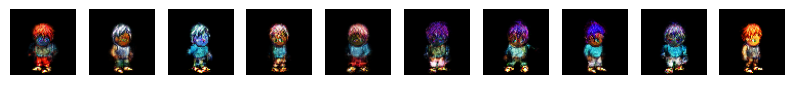

Epoch 32: Train Loss: 1319.7505, BCE: 1287.3443, KLD1: 29.9318, KLD2: 2.4745
Epoch 32: Test Loss: 1327.5679, BCE: 1295.4830, KLD1: 29.6037, KLD2: 2.4812


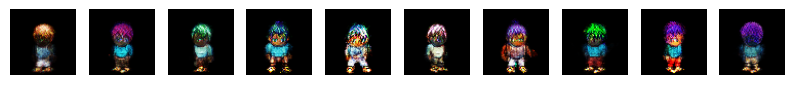

Epoch 33: Train Loss: 1319.3969, BCE: 1287.0016, KLD1: 29.9200, KLD2: 2.4752
Epoch 33: Test Loss: 1319.3402, BCE: 1287.0353, KLD1: 29.8913, KLD2: 2.4136


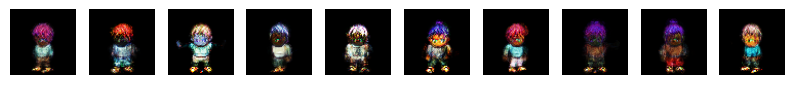

Epoch 34: Train Loss: 1319.0269, BCE: 1286.6635, KLD1: 29.8893, KLD2: 2.4741
Epoch 34: Test Loss: 1330.4733, BCE: 1297.6757, KLD1: 30.3070, KLD2: 2.4906


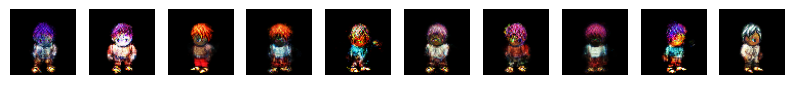

Epoch 35: Train Loss: 1318.7481, BCE: 1286.3967, KLD1: 29.8764, KLD2: 2.4749
Epoch 35: Test Loss: 1320.7182, BCE: 1288.6529, KLD1: 29.6177, KLD2: 2.4475


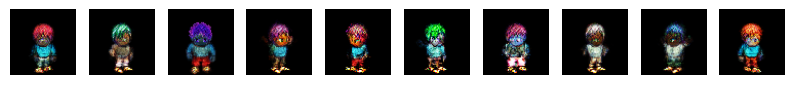

Epoch 36: Train Loss: 1318.1976, BCE: 1285.8835, KLD1: 29.8293, KLD2: 2.4848
Epoch 36: Test Loss: 1319.9791, BCE: 1287.8183, KLD1: 29.7155, KLD2: 2.4454


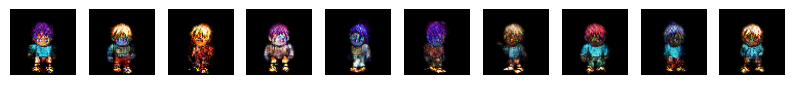

Epoch 37: Train Loss: 1317.9235, BCE: 1285.6244, KLD1: 29.8158, KLD2: 2.4832
Epoch 37: Test Loss: 1322.0811, BCE: 1289.5167, KLD1: 30.1249, KLD2: 2.4395


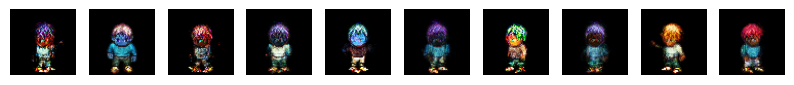

Epoch 38: Train Loss: 1317.6415, BCE: 1285.3355, KLD1: 29.8177, KLD2: 2.4882
Epoch 38: Test Loss: 1321.8723, BCE: 1289.9150, KLD1: 29.4530, KLD2: 2.5043


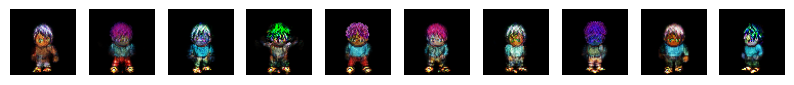

Epoch 39: Train Loss: 1317.3786, BCE: 1285.1517, KLD1: 29.7435, KLD2: 2.4834
Epoch 39: Test Loss: 1321.1664, BCE: 1288.3699, KLD1: 30.3044, KLD2: 2.4920


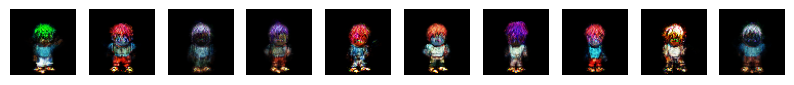

Epoch 40: Train Loss: 1317.0615, BCE: 1284.8379, KLD1: 29.7360, KLD2: 2.4876
Epoch 40: Test Loss: 1319.2657, BCE: 1287.2269, KLD1: 29.5524, KLD2: 2.4863


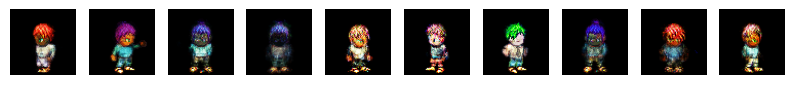

Epoch 41: Train Loss: 1316.8829, BCE: 1284.6881, KLD1: 29.7029, KLD2: 2.4919
Epoch 41: Test Loss: 1318.7931, BCE: 1286.5748, KLD1: 29.7489, KLD2: 2.4695


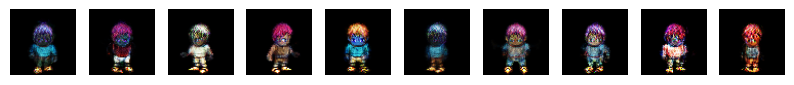

Epoch 42: Train Loss: 1316.6023, BCE: 1284.4015, KLD1: 29.7070, KLD2: 2.4937
Epoch 42: Test Loss: 1321.0091, BCE: 1288.8960, KLD1: 29.5865, KLD2: 2.5267


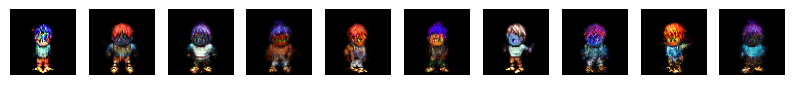

Epoch 43: Train Loss: 1316.4386, BCE: 1284.2243, KLD1: 29.7173, KLD2: 2.4969
Epoch 43: Test Loss: 1321.0335, BCE: 1288.1500, KLD1: 30.3942, KLD2: 2.4893


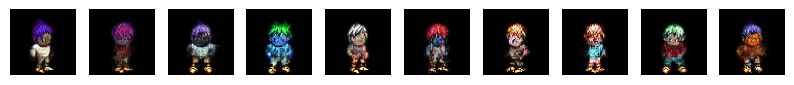

Epoch 44: Train Loss: 1315.9696, BCE: 1283.7863, KLD1: 29.6861, KLD2: 2.4971
Epoch 44: Test Loss: 1317.6060, BCE: 1286.2693, KLD1: 28.8617, KLD2: 2.4750


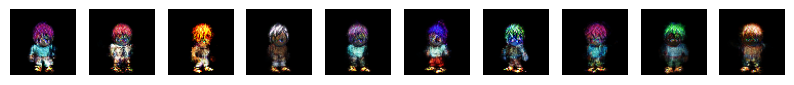

Epoch 45: Train Loss: 1315.9521, BCE: 1283.7621, KLD1: 29.6927, KLD2: 2.4973
Epoch 45: Test Loss: 1321.5345, BCE: 1289.2438, KLD1: 29.7975, KLD2: 2.4933


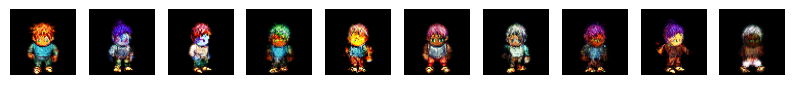

Epoch 46: Train Loss: 1315.5955, BCE: 1283.4659, KLD1: 29.6341, KLD2: 2.4955
Epoch 46: Test Loss: 1320.3941, BCE: 1286.9013, KLD1: 30.9786, KLD2: 2.5142


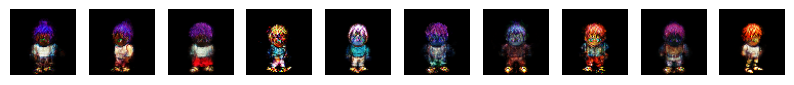

Epoch 47: Train Loss: 1315.5833, BCE: 1283.4547, KLD1: 29.6279, KLD2: 2.5007
Epoch 47: Test Loss: 1316.9614, BCE: 1285.1665, KLD1: 29.2858, KLD2: 2.5092


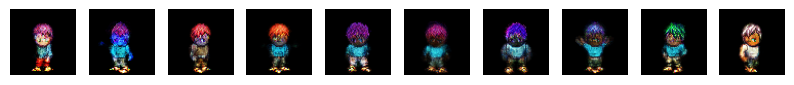

Epoch 48: Train Loss: 1315.1751, BCE: 1283.0828, KLD1: 29.5908, KLD2: 2.5015
Epoch 48: Test Loss: 1322.6589, BCE: 1291.1474, KLD1: 29.0208, KLD2: 2.4906


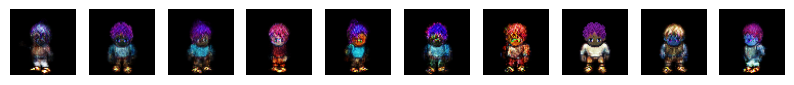

Epoch 49: Train Loss: 1315.2359, BCE: 1283.1380, KLD1: 29.5948, KLD2: 2.5030
Epoch 49: Test Loss: 1316.8743, BCE: 1285.2164, KLD1: 29.1606, KLD2: 2.4974


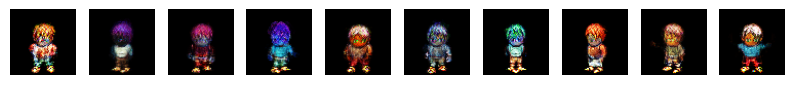

Epoch 50: Train Loss: 1314.7726, BCE: 1282.7293, KLD1: 29.5398, KLD2: 2.5034
Epoch 50: Test Loss: 1321.8478, BCE: 1288.8985, KLD1: 30.4698, KLD2: 2.4795


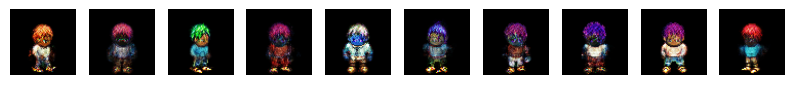

In [ ]:

# Almacenar las pérdidas
train_losses = []
test_losses = []

def loss_function_hvae(recon_x, x, mu1, logvar1, mu2, logvar2):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, feature_size), reduction='sum')
    
    # KL divergencia para z1
    KLD1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())  
    
    # KL divergencia para z2
    KLD2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())  
    
    return BCE + KLD1 + KLD2, BCE, KLD1, KLD2
def train(epoch):
    model.train()
    total_loss = 0
    total_bce = 0
    total_kld1 = 0
    total_kld2 = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1, feature_size)  # Aplanar imágenes a vectores
        optimizer.zero_grad()
        recon_batch, mu1, logvar1, mu2, logvar2 = model(data)
        loss, bce, kld1, kld2 = loss_function_hvae(recon_batch, data, mu1, logvar1, mu2, logvar2)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld1 += kld1.item()
        total_kld2 += kld2.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld1 = total_kld1 / len(train_loader.dataset)
    avg_kld2 = total_kld2 / len(train_loader.dataset)

    train_losses.append((avg_loss, avg_bce, avg_kld1, avg_kld2))
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD1: {avg_kld1:.4f}, KLD2: {avg_kld2:.4f}")

def test(epoch):
    model.eval()
    total_loss = 0
    total_bce = 0
    total_kld1 = 0
    total_kld2 = 0

    with torch.no_grad():
        for (data, _) in test_loader:
            data = data.to(device)
            recon_batch, mu1, logvar1, mu2, logvar2 = model(data)
            loss, bce, kld1, kld2 = loss_function_hvae(recon_batch, data, mu1, logvar1, mu2, logvar2)

            total_loss += loss.item()
            total_bce += bce.item()
            total_kld1 += kld1.item()
            total_kld2 += kld2.item()

    avg_loss = total_loss / len(test_loader.dataset)
    avg_bce = total_bce / len(test_loader.dataset)
    avg_kld1 = total_kld1 / len(test_loader.dataset)
    avg_kld2 = total_kld2 / len(test_loader.dataset)

    test_losses.append((avg_loss, avg_bce, avg_kld1, avg_kld2))
    print(f"Epoch {epoch}: Test Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD1: {avg_kld1:.4f}, KLD2: {avg_kld2:.4f}")


# Entrenamiento
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    #Dibujar entre epocas
    with torch.no_grad():
        sample_z1 = torch.randn(10, latent_size // 2).to(device)
        sample_z2 = torch.randn(10, latent_size // 2).to(device)
        sample = model.decode(sample_z1,sample_z2).cpu()
        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for j in range(10):
            axes[j].imshow(sample.view(10, 3, 64, 64)[j].permute(1, 2, 0).cpu().numpy())
            axes[j].axis("off")
        plt.show()


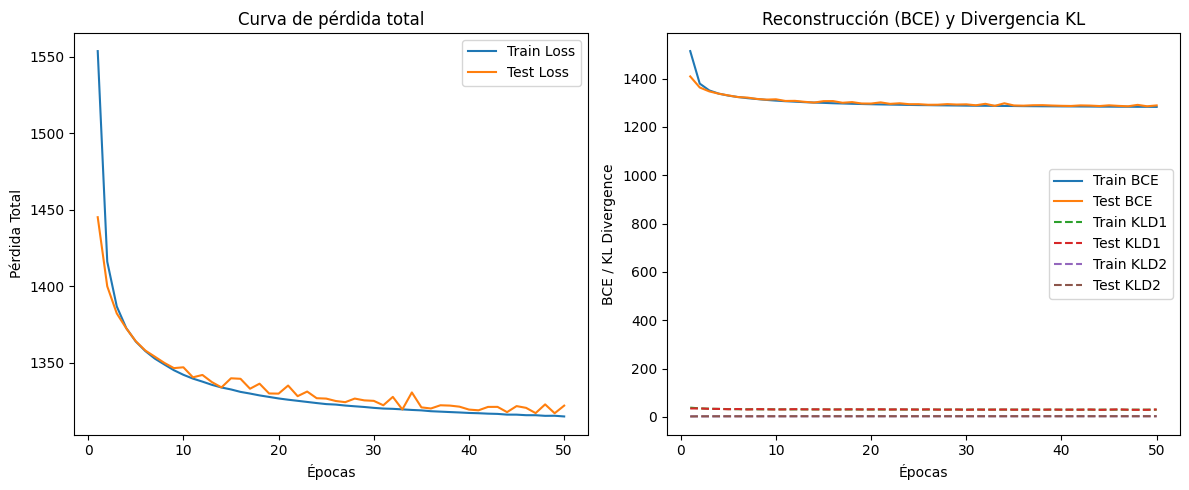

In [ ]:
# Graficar curvas de pérdida
epochs_range = range(1, epochs + 1)
train_loss, train_bce, train_kld1,train_kld2 = zip(*train_losses)
test_loss, test_bce, test_kld1,test_kld2 = zip(*test_losses)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, test_loss, label="Test Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida Total")
plt.legend()
plt.title("Curva de pérdida total")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bce, label="Train BCE")
plt.plot(epochs_range, test_bce, label="Test BCE")
plt.plot(epochs_range, train_kld1, label="Train KLD1", linestyle="dashed")
plt.plot(epochs_range, test_kld1, label="Test KLD1", linestyle="dashed")
plt.plot(epochs_range, train_kld2, label="Train KLD2", linestyle="dashed")
plt.plot(epochs_range, test_kld2, label="Test KLD2", linestyle="dashed")
plt.xlabel("Épocas")
plt.ylabel("BCE / KL Divergence")
plt.legend()
plt.title("Reconstrucción (BCE) y Divergencia KL")

plt.tight_layout()
plt.show()

Tiempo promedio por imagen: 0.0194 segundos
Uso de RAM: -2.17 MB
Uso de VRAM: -4.00 MB


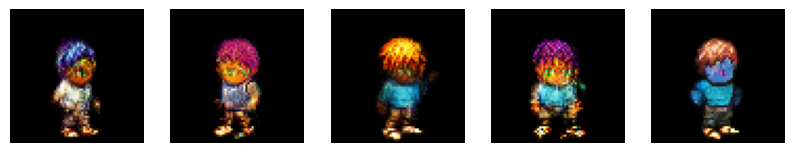

In [ ]:
import time
import psutil  # Para medir uso de CPU/RAM
import GPUtil  # Para medir uso de GPU

def get_gpu_memory():
    """Obtiene el uso actual de memoria de la GPU en MB."""
    gpus = GPUtil.getGPUs()
    if gpus:
        return gpus[0].memoryUsed
    return 0  # Si no hay GPU, devuelve 0

def generate_images_HVAE(model, num_samples=5):
    model.eval()  # Modo evaluación
   
    # Medir uso inicial de recursos
    start_time = time.time()
    initial_ram = psutil.virtual_memory().used / (1024 ** 2)  # RAM en MB
    initial_gpu = get_gpu_memory()  # VRAM en MB

    with torch.no_grad():
        # Generar puntos aleatorios en el espacio latente
        z1 = torch.randn(num_samples, latent_size // 2).to(device)
        z2 = torch.randn(num_samples, latent_size // 2).to(device)
        # Decodificar para obtener imágenes
        generated_images = model.decode(z1,z2).cpu()
        generated_images = generated_images.view(-1, 3, 64, 64)  # RGB format

    # Medir uso final de recursos
    end_time = time.time()
    final_ram = psutil.virtual_memory().used / (1024 ** 2)  # RAM en MB
    final_gpu = get_gpu_memory()  # VRAM en MB

    # Calcular métricas
    execution_time = (end_time - start_time) / num_samples
    ram_used = final_ram - initial_ram
    gpu_used = final_gpu - initial_gpu

    print(f"Tiempo promedio por imagen: {execution_time:.4f} segundos")
    print(f"Uso de RAM: {ram_used:.2f} MB")
    print(f"Uso de VRAM: {gpu_used:.2f} MB")

    # Mostrar las imágenes con la clase
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = generated_images[i].permute(1, 2, 0).numpy()  # Reordenar ejes
        img = (img - img.min()) / (img.max() - img.min())  # Normalizar a [0,1]
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Llamar a la función para generar imágenes
generate_images_HVAE(model, num_samples=5)